# **Phishing URL detection: pre-processing synthetic dataset**

**RQ1:** What characteristics provide the greatest discriminatory information for identifying phishing sites compared to legitimate ones?  

**RQ2:** Do synthetic data generated by Large Language Models preserve the same statistical properties as real data?

**RQ3:** What are the main differences between synthetic data generated by LLMs and real data in regression and clustering contexts?

**RQ4:** Can the features generated by LLMs be mapped to known statistical distributions?

<br>

**Author:** Raffaele Aurucci

## **Reading synthetic dataset**

### 1. Preliminary operation

In [1]:
download.file("https://drive.google.com/uc?id=1EhxGpQLGOs_ToQdzwJoehDIVl83fioVH&export=download", "Phishing_URL_Synthetic_Dataset_3.csv")

In [ ]:
if (!require(moments)) install.packages("moments")

library(moments)
library(utils)

In [2]:
df <- read.csv('Phishing_URL_Synthetic_Dataset_3.csv', sep = ",")

head(df, 10)

,URLLength,DomainLength,TLDEncoding,NoOfLettersInURL,NoOfDigitsInURL,NoOfSpecialCharsInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,⋯,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfExternalFiles,HasDescription,HasSocialNet,HasCopyrightInfo,label
,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,45,25,0.32,30,4,5,0,300,2000,0,⋯,10.5,25.4,0,0,0,20,0,0,0,0
2,60,30,0.20,35,5,4,0,210,1800,0,⋯,0.0,0.0,0,0,0,10,0,0,0,0
3,28,18,0.40,12,2,1,0,100,1500,1,⋯,15.0,22.0,0,0,0,5,0,0,0,0
4,75,40,0.10,45,10,6,0,400,3000,0,⋯,0.0,0.0,0,0,0,0,0,0,0,0
5,90,50,0.25,40,6,2,0,150,2500,1,⋯,5.5,10.2,0,0,0,12,0,0,0,0
6,55,35,0.35,28,4,3,0,320,2200,0,⋯,20.0,35.7,0,0,1,10,0,0,0,0
7,42,22,0.30,20,2,2,0,250,1000,0,⋯,0.0,0.0,0,0,0,8,0,0,0,0
8,100,60,0.15,50,8,8,0,500,4500,0,⋯,25.4,30.1,0,0,0,15,0,0,0,0
9,39,27,0.38,15,3,2,1,80,900,0,⋯,10.0,12.0,0,0,0,5,0,0,0,0


In [ ]:
str(df)

'data.frame':	12239 obs. of  21 variables:
 $ URLLength            : int  45 60 28 75 90 55 42 100 39 62 ...
 $ DomainLength         : int  25 30 18 40 50 35 22 60 27 33 ...
 $ TLDEncoding          : num  0.32 0.2 0.4 0.1 0.25 0.35 0.3 0.15 0.38 0.27 ...
 $ NoOfLettersInURL     : int  30 35 12 45 40 28 20 50 15 32 ...
 $ NoOfDigitsInURL      : int  4 5 2 10 6 4 2 8 3 5 ...
 $ NoOfSpecialCharsInURL: int  5 4 1 6 2 3 2 8 2 5 ...
 $ IsHTTPS              : int  0 0 0 0 0 0 0 0 1 0 ...
 $ LineOfCode           : int  300 210 100 400 150 320 250 500 80 90 ...
 $ LargestLineLength    : int  2000 1800 1500 3000 2500 2200 1000 4500 900 2000 ...
 $ HasTitle             : int  0 0 1 0 1 0 0 0 0 0 ...
 $ NoOfReference        : int  5 2 8 0 3 4 2 10 1 0 ...
 $ DomainTitleMatchScore: num  10.5 0 15 0 5.5 20 0 25.4 10 0 ...
 $ URLTitleMatchScore   : num  25.4 0 22 0 10.2 35.7 0 30.1 12 0 ...
 $ HasFavicon           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Robots               : int  0 0 0 0 0 0 0 0 0 0 ...
 

In [7]:
# count NA values
labels = names(df)

for (label in labels) {
  na_count <- sum(is.na(df[[label]]))
  if (na_count > 0)
    print(paste(label, ":", na_count))
}

# delete duplicated observations
df <- df[!duplicated(df), ]

# reset indices
row.names(df) <- NULL

# disable scientific notation view
options(scipen = 999)


# moda function
moda <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}


# count outliers function
count_outliers <- function(df, column) {

  q1 <- quantile(df[[column]], 0.25)
  q3 <- quantile(df[[column]], 0.75)

  iqr <- q3 - q1

  lower_bound <- q1 - 1.5 * iqr
  upper_bound <- q3 + 1.5 * iqr

  outliers <- sum(df[[column]] < lower_bound | df[[column]] > upper_bound)

  return(outliers)
}


# calculate overlap median function
calculate_overlap_median <- function(df_0, df_1, column) {

  # class 0
  IQR_0 <- quantile(df_0[[column]], 0.75) - quantile(df_0[[column]], 0.25)
  M1_0 <- quantile(df_0[[column]], 0.5) - 1.57 * IQR_0 / sqrt(length(df_0[[column]]))
  M2_0 <- quantile(df_0[[column]], 0.5) + 1.57 * IQR_0 / sqrt(length(df_0[[column]]))

  # class 1
  IQR_1 <- quantile(df_1[[column]], 0.75) - quantile(df_1[[column]], 0.25)
  M1_1 <- quantile(df_1[[column]], 0.5) - 1.57 * IQR_1 / sqrt(length(df_1[[column]]))
  M2_1 <- quantile(df_1[[column]], 0.5) + 1.57 * IQR_1 / sqrt(length(df_1[[column]]))

  return(list(
    "df_0" = list("M1" = M1_0, "M2" = M2_0),
    "df_1" = list("M1" = M1_1, "M2" = M2_1)
  ))
}

### 2. Feature **label**

*   0 indicate **phishing** URL
*   1 indicate **legitimate** URL

In [4]:
table(df$label)


   0    1 
5062 5103 

In [5]:
# undersampling to balance dataset
indices_label_1 <- which(df$label == 1)
indices_to_remove <- sample(indices_label_1, 41) # 41
df <- df[-indices_to_remove, ]
row.names(df) <- NULL

# divide dataset
df_0 <- df[df$label == 0, ]
df_1 <- df[df$label == 1, ]

table(df$label)


   0    1 
5062 5062 

## **Descriptive Statistics.**

### 3. Feature **URLLength**

In [ ]:
# dispersion
summary(df$URLLength)

cat('\nvar: ', var(df$URLLength), '\n')
cat('std: ', sd(df$URLLength))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.0    38.0    68.0   172.6   135.0  1300.0 


var:  88823.36 
std:  298.0325

#### Distribution form

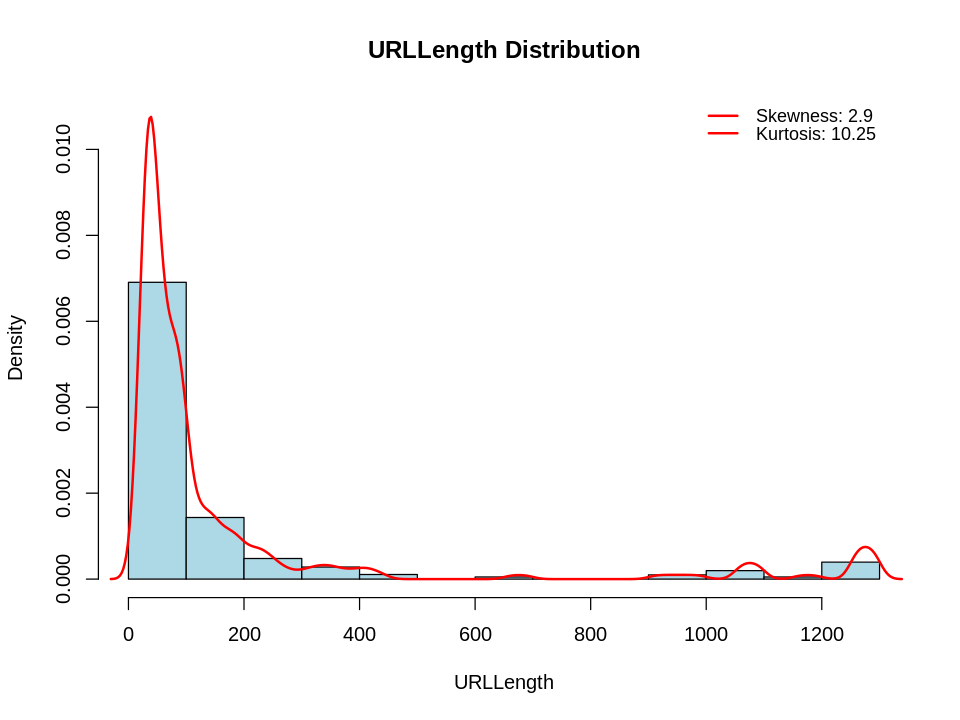

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

n <- length(df$URLLength)
h_sturges <- (max(df$URLLength) - min(df$URLLength)) / sqrt(n)
dens <- density(df$URLLength, bw = h_sturges)

hist(df$URLLength,
     main = "URLLength Distribution",
     xlab = "URLLength",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens$y)))

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$URLLength)
kurtosis_value <- kurtosis(df$URLLength)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

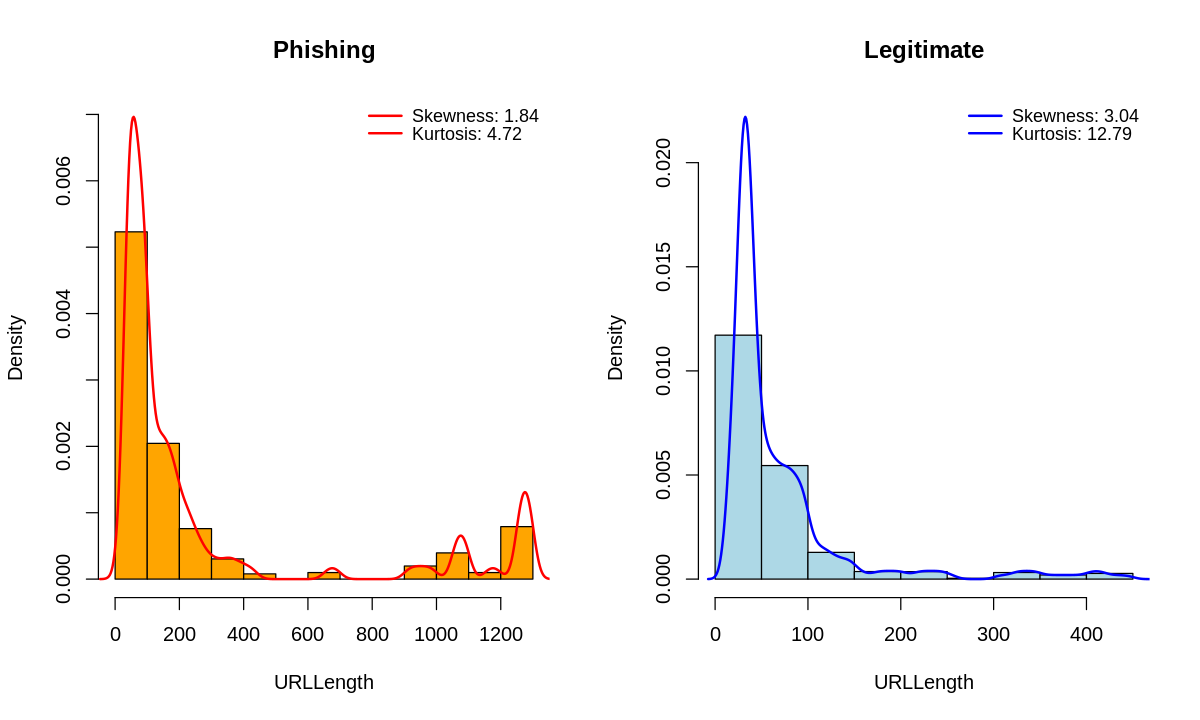

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Sturges rule
n_0 <- length(df_0$URLLength)
h_sturges_0 <- (max(df_0$URLLength) - min(df_0$URLLength)) / sqrt(n_0)
dens_0 <- density(df_0$URLLength, bw = h_sturges_0)

n_1 <- length(df_1$URLLength)
h_sturges_1 <- (max(df_1$URLLength) - min(df_1$URLLength)) / sqrt(n_1)
dens_1 <- density(df_1$URLLength, bw = h_sturges_1)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$URLLength)
kurtosis_value_0 <- kurtosis(df_0$URLLength)

skw_value_1 <- skewness(df_1$URLLength)
kurtosis_value_1 <- kurtosis(df_1$URLLength)

par(mfrow = c(1, 2))

# Phishing
hist(df_0$URLLength,
     main = "Phishing",
     xlab = "URLLength",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_0$y)))

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$URLLength,
     main = "Legitimate",
     xlab = "URLLength",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_1$y)))

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

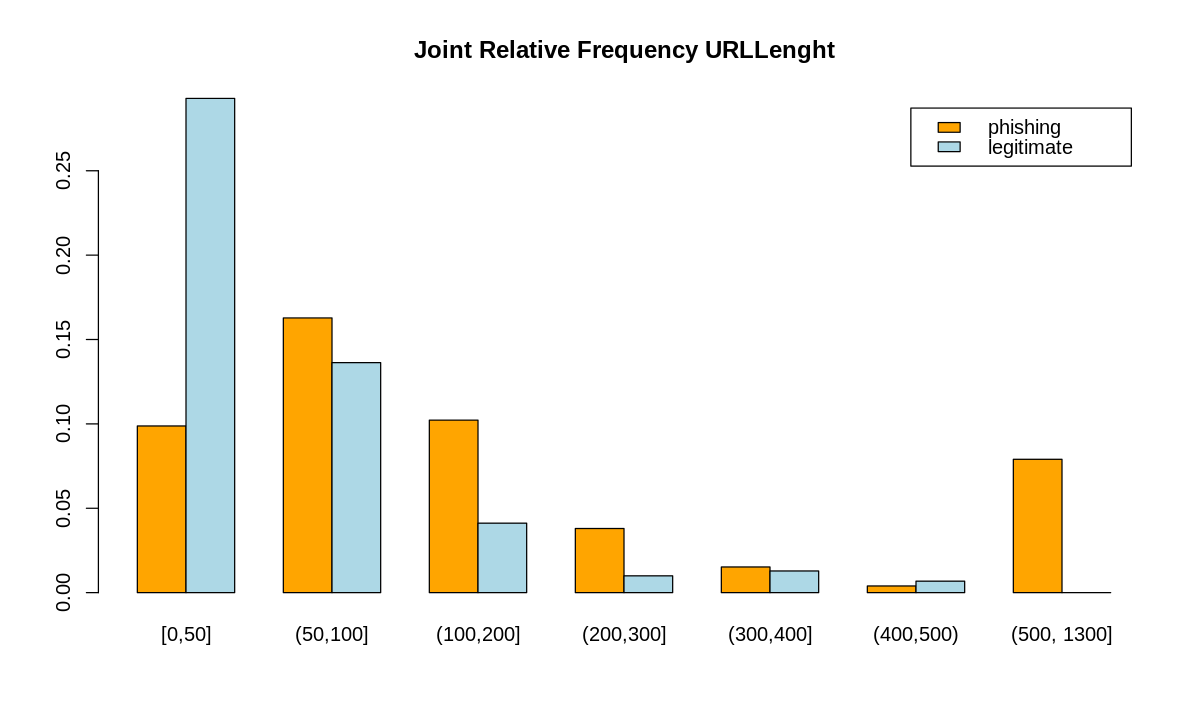

In [ ]:
breaks <- c(0, 50, 100, 200, 300, 400, 500, 1300)

labels <- c("[0,50]", "(50,100]", "(100,200]", "(200,300]", "(300,400]", "(400,500)", "(500, 1300]")

j_freq <- table(df$label, cut(df$URLLength, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# plot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        legend = c("phishing", "legitimate"),
        main = "Joint Relative Frequency URLLenght", beside=TRUE)

#### Outliers and overlap median

In [ ]:
summary(df_0$URLLength)
summary(df_1$URLLength)

outliers <- count_outliers(df, "URLLength")
outliers_0 <- count_outliers(df_0, "URLLength")
outliers_1 <- count_outliers(df_1, "URLLength")

cat('\nn. outliers URLLength: \t \t', outliers)
cat('\nn. outliers URLLength (0): \t', outliers_0)
cat('\nn. outliers URLLength (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.0    58.0    96.5   275.9   221.0  1300.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.00   31.00   41.00   69.37   79.00  450.00 


n. outliers URLLength: 	 	 1229
n. outliers URLLength (0): 	 800
n. outliers URLLength (1): 	 389

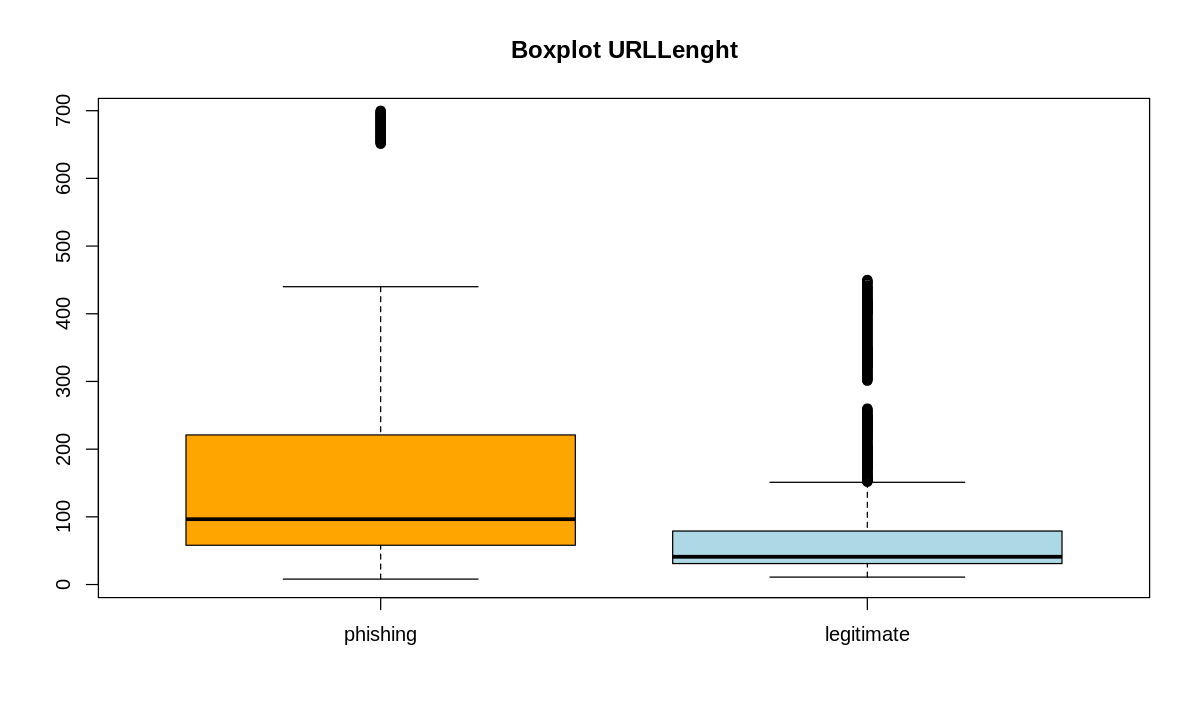

In [ ]:
boxplot(df_0$URLLength, df_1$URLLength,
        ylim = c(min(df_0$URLLength), quantile(df_0$URLLength, 0.85)),
        main = 'Boxplot URLLenght', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "URLLength")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 92.90312 M2 = 100.0969 
Overlap df_1: M1 = 39.9408 M2 = 42.0592 


#### Correlation with label

In [ ]:
pearson <- cor(df$URLLength, df$label)
spearman <- cor(df$URLLength, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.3464976
Spearman: 	 -0.4941306

### 4. Feature **DomainLength**

In [ ]:
# dispersion
summary(df$DomainLength)

cat('\nvar: ', var(df$DomainLength), '\n')
cat('std: ', sd(df$DomainLength))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4.00   21.00   30.00   39.02   45.00  270.00 


var:  1198.389 
std:  34.61775

#### Distribution form

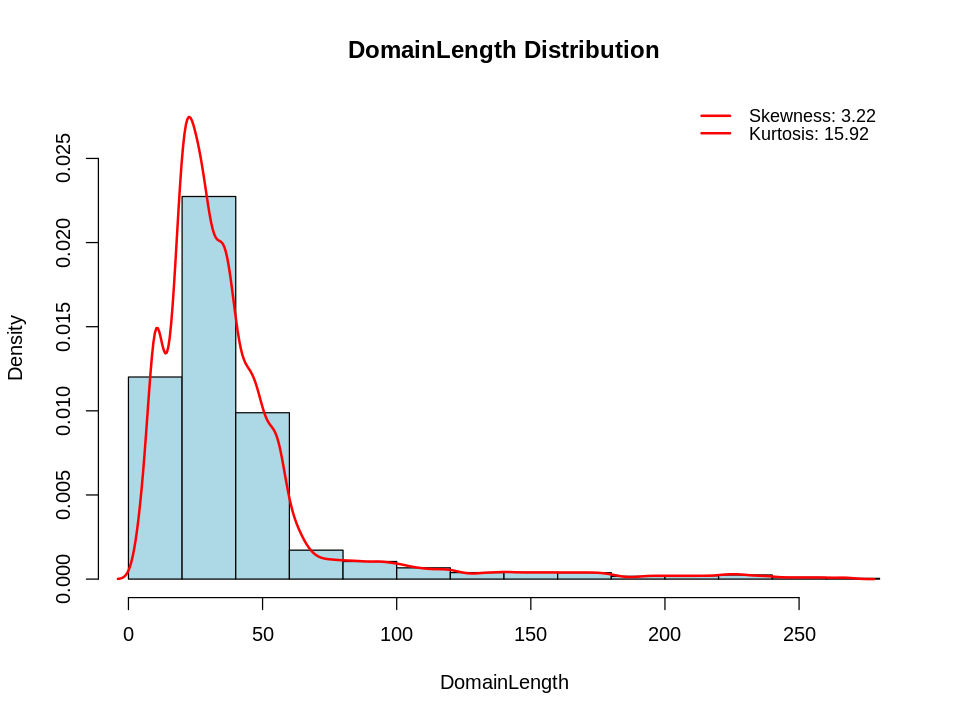

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

n <- length(df$DomainLength)
h_sturges <- (max(df$DomainLength) - min(df$DomainLength)) / sqrt(n)
dens <- density(df$DomainLength, bw = h_sturges)

hist(df$DomainLength,
     main = "DomainLength Distribution",
     xlab = "DomainLength",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens$y)))

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$DomainLength)
kurtosis_value <- kurtosis(df$DomainLength)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

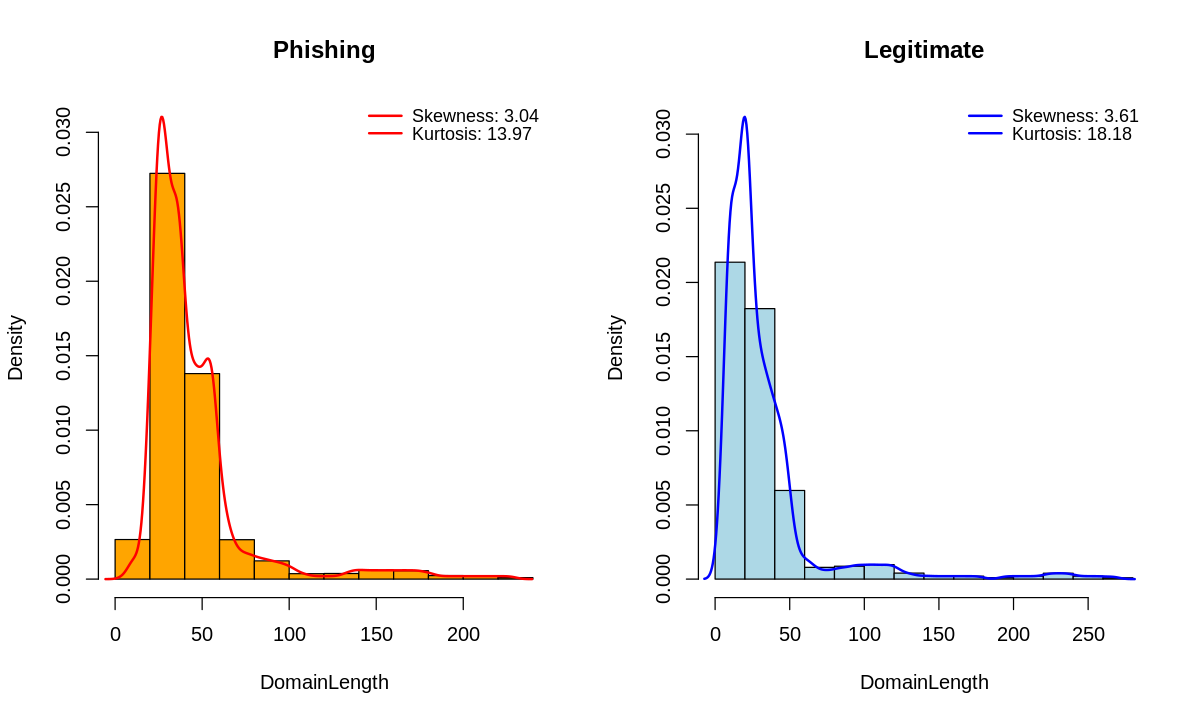

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Sturges rule
n_0 <- length(df_0$DomainLength)
h_sturges_0 <- (max(df_0$DomainLength) - min(df_0$DomainLength)) / sqrt(n_0)
dens_0 <- density(df_0$DomainLength, bw = h_sturges_0)

n_1 <- length(df_1$DomainLength)
h_sturges_1 <- (max(df_1$DomainLength) - min(df_1$DomainLength)) / sqrt(n_1)
dens_1 <- density(df_1$DomainLength, bw = h_sturges_1)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$DomainLength)
kurtosis_value_0 <- kurtosis(df_0$DomainLength)

skw_value_1 <- skewness(df_1$DomainLength)
kurtosis_value_1 <- kurtosis(df_1$DomainLength)


par(mfrow = c(1, 2))

# Phishing
hist(df_0$DomainLength,
     main = "Phishing",
     xlab = "DomainLength",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_0$y)))

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$DomainLength,
     main = "Legitimate",
     xlab = "DomainLength",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_1$y)))

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

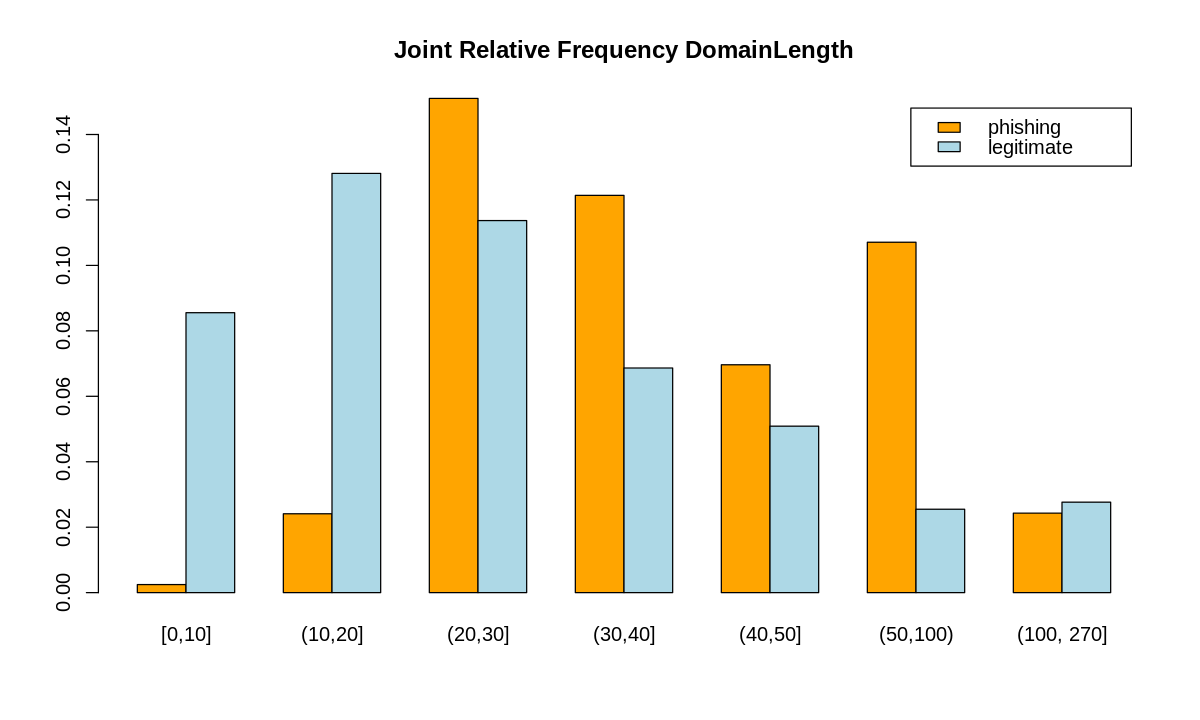

In [ ]:
breaks <- c(0, 10, 20, 30, 40, 50, 100, 270)

labels <- c("[0,10]", "(10,20]", "(20,30]", "(30,40]", "(40,50]", "(50,100)", "(100, 270]")

j_freq <- table(df$label, cut(df$DomainLength, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

barplot(j_freq_rel, col = c("orange", "lightblue"),
        legend = c("phishing", "legitimate"),
        main = "Joint Relative Frequency DomainLength", beside=TRUE)

#### Outliers and overlap median

In [ ]:
summary(df_0$DomainLength)
summary(df_1$DomainLength)

outliers <- count_outliers(df, "DomainLength")
outliers_0 <- count_outliers(df_0, "DomainLength")
outliers_1 <- count_outliers(df_1, "DomainLength")

cat('\nn. outliers DomainLength: \t', outliers)
cat('\nn. outliers DomainLength (0): \t', outliers_0)
cat('\nn. outliers DomainLength (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4.00   27.00   36.00   44.73   52.00  230.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4.00   15.00   22.00   33.31   37.00  270.00 


n. outliers DomainLength: 	 726
n. outliers DomainLength (0): 	 307
n. outliers DomainLength (1): 	 398

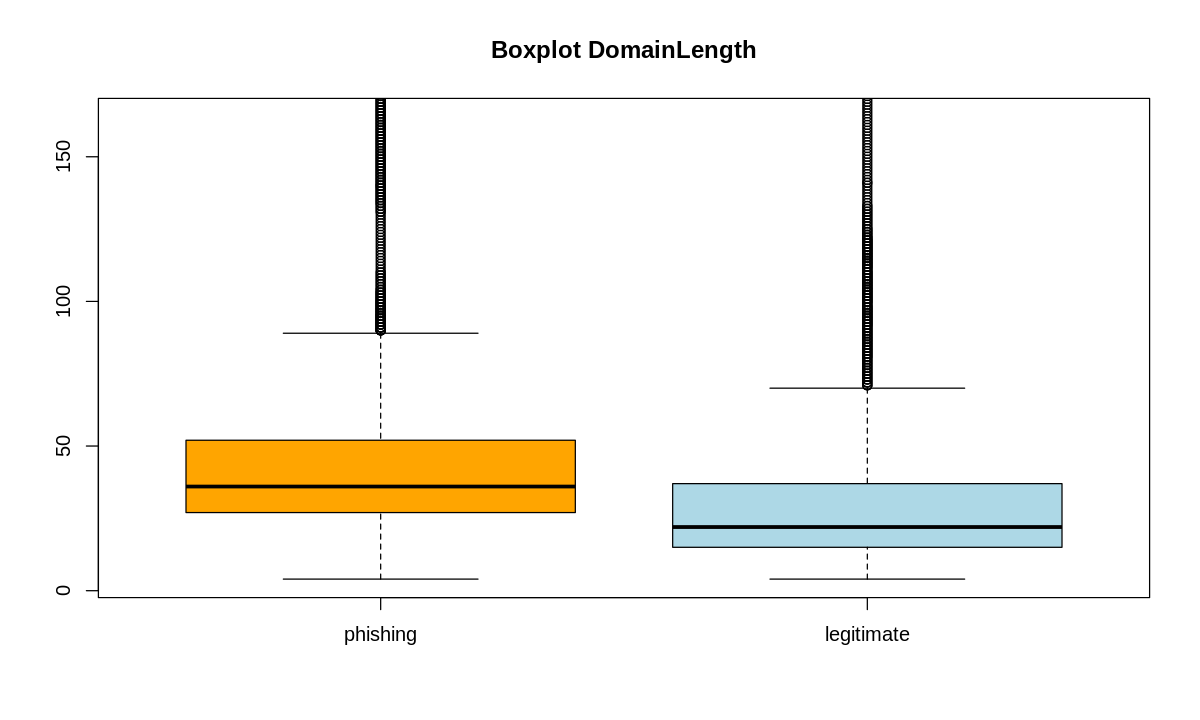

In [ ]:
boxplot(df_0$DomainLength, df_1$DomainLength,
        main = 'Boxplot DomainLength', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$DomainLength), quantile(df_0$DomainLength, 0.98)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "DomainLength")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 35.44833 M2 = 36.55167 
Overlap df_1: M1 = 21.51453 M2 = 22.48547 


#### Correlation with label

In [ ]:
pearson <- cor(df$DomainLength, df$label)
spearman <- cor(df$DomainLength, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.165055
Spearman: 	 -0.3966263

### 5. Feature **TLD**

In [ ]:
# dispersion
summary(df$TLDEncoding)

cat('\nvar: ', var(df$TLDEncoding), '\n')
cat('std: ', sd(df$TLDEncoding))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.3680  0.5810  0.5481  0.7400  1.0000 


var:  0.06143398 
std:  0.2478588

#### Distribution form

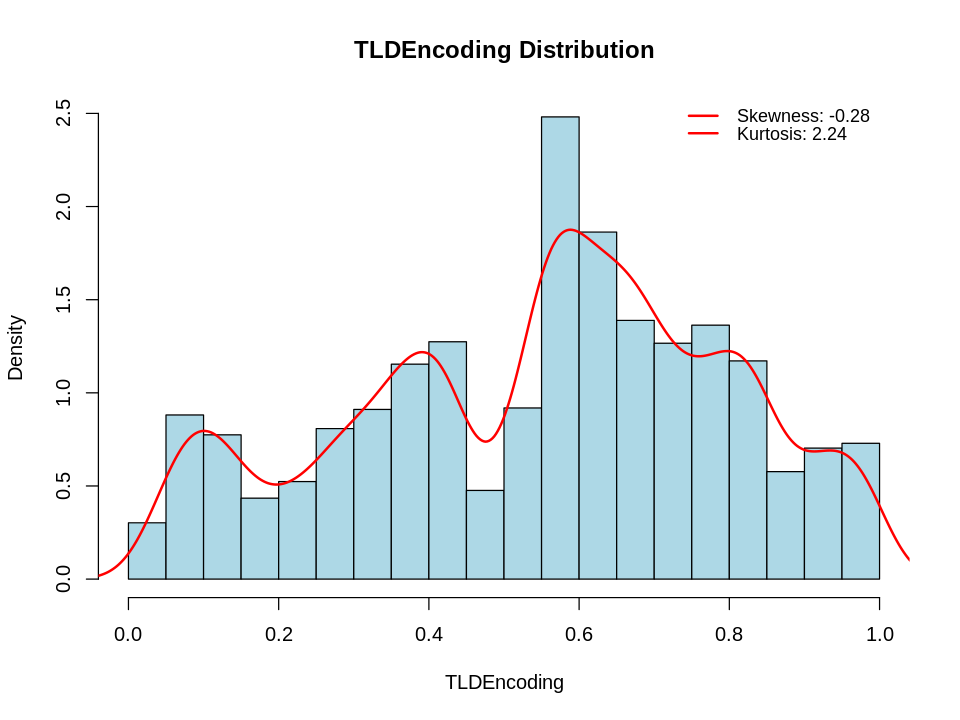

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

dens <- density(df$TLDEncoding)

hist(df$TLDEncoding,
     main = "TLDEncoding Distribution",
     xlab = "TLDEncoding",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
    )

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$TLDEncoding)
kurtosis_value <- kurtosis(df$TLDEncoding)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

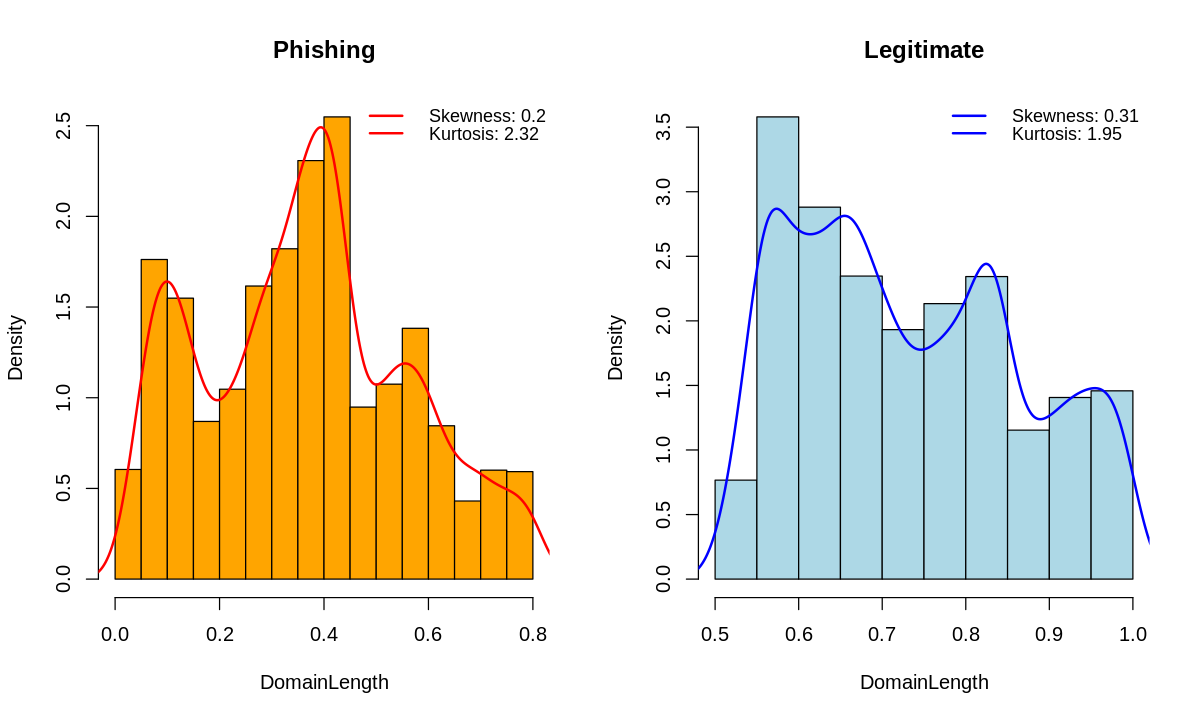

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

dens_0 <- density(df_0$TLDEncoding)
dens_1 <- density(df_1$TLDEncoding)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$TLDEncoding)
kurtosis_value_0 <- kurtosis(df_0$TLDEncoding)

skw_value_1 <- skewness(df_1$TLDEncoding)
kurtosis_value_1 <- kurtosis(df_1$TLDEncoding)

par(mfrow = c(1, 2))

# Phishing
hist(df_0$TLDEncoding,
     main = "Phishing",
     xlab = "DomainLength",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     )

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2)


# Legitimate
hist(df_1$TLDEncoding,
     main = "Legitimate",
     xlab = "DomainLength",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     )

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

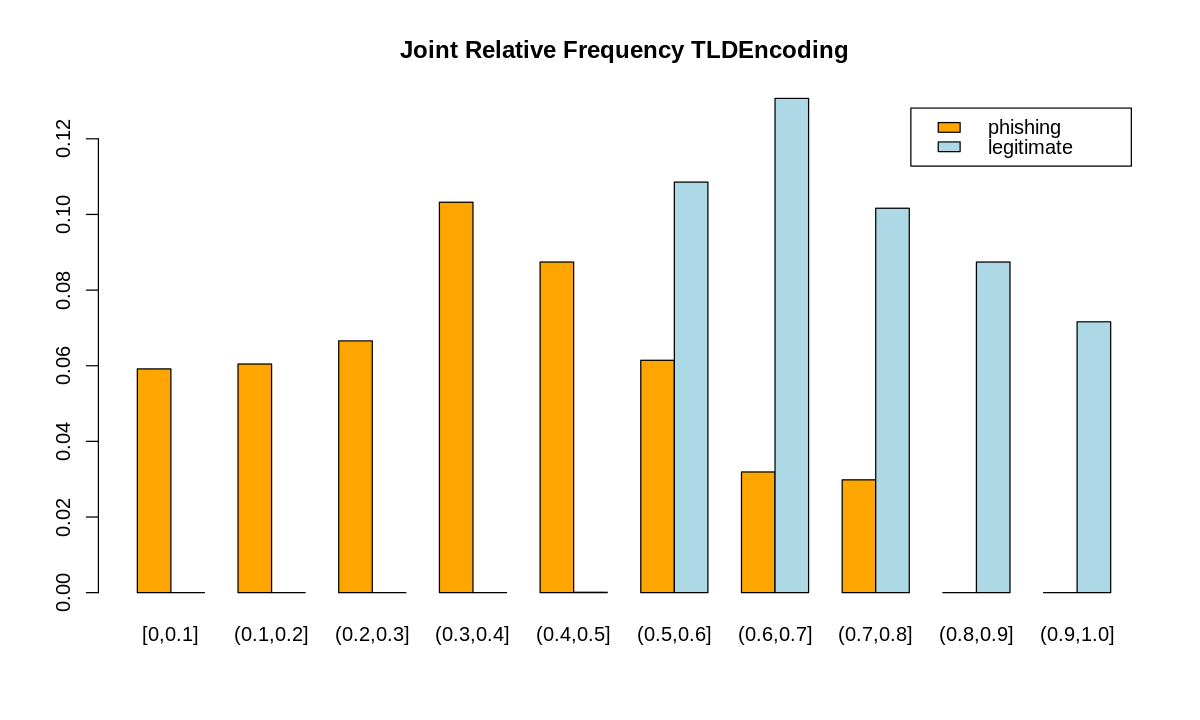

In [ ]:
# distribution
breaks <- c(-1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)

labels <- c("[0,0.1]", "(0.1,0.2]", "(0.2,0.3]", "(0.3,0.4]", "(0.4,0.5]",
            "(0.5,0.6]", "(0.6,0.7]", "(0.7,0.8]", "(0.8,0.9]", "(0.9,1.0]")

j_freq <- table(df$label, cut(df$TLDEncoding, breaks = breaks, labels = labels))
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        legend = c("phishing", "legitimate"),
        main = "Joint Relative Frequency TLDEncoding", beside=TRUE)

#### Outliers and overlap median

In [ ]:
summary(df_0$TLDEncoding)
summary(df_1$TLDEncoding)

outliers <- count_outliers(df, "TLDEncoding")
outliers_0 <- count_outliers(df_0, "TLDEncoding")
outliers_1 <- count_outliers(df_1, "TLDEncoding")

cat('\nn. outliers TLDEncoding: \t', outliers)
cat('\nn. outliers TLDEncoding (0): \t', outliers_0)
cat('\nn. outliers TLDEncoding (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2122  0.3680  0.3649  0.4988  0.8000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5000  0.6200  0.7100  0.7314  0.8300  1.0000 


n. outliers TLDEncoding: 	 0
n. outliers TLDEncoding (0): 	 0
n. outliers TLDEncoding (1): 	 0

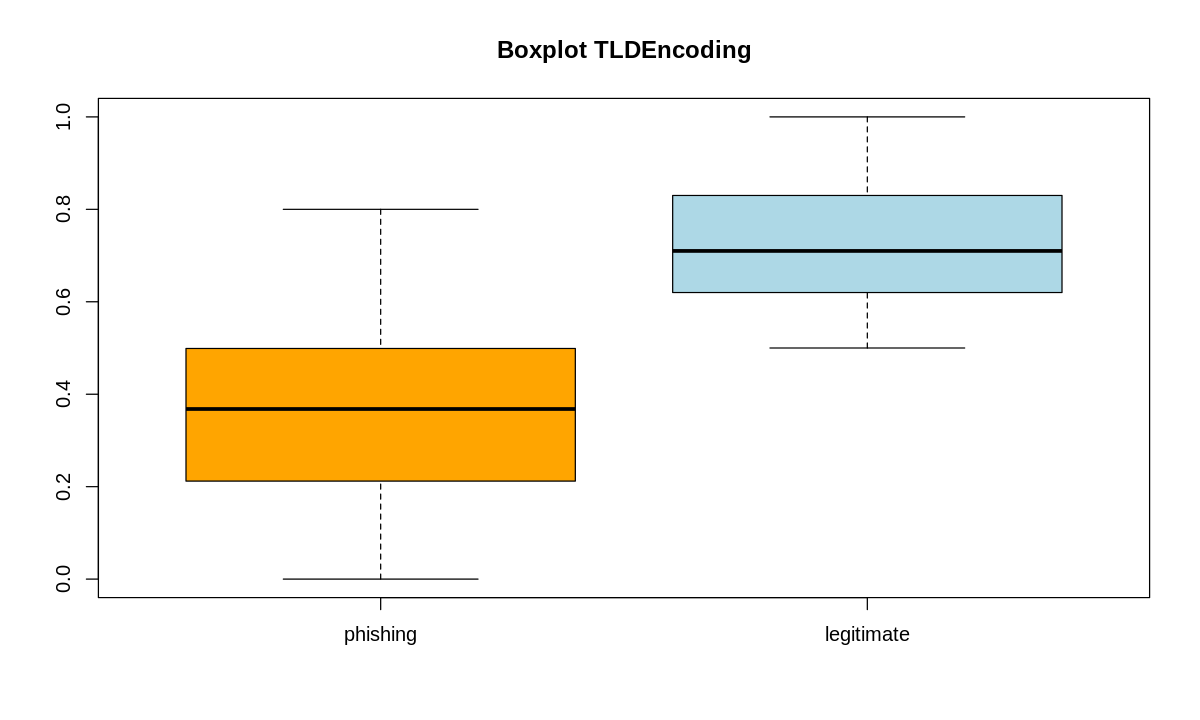

In [ ]:
boxplot(df_0$TLDEncoding, df_1$TLDEncoding,
        main = 'Boxplot TLDEncoding', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "TLDEncoding")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 0.3616779 M2 = 0.3743221 
Overlap df_1: M1 = 0.705366 M2 = 0.714634 


#### Correlation with label

In [ ]:
pearson <- cor(df$TLDEncoding, df$label)
spearman <- cor(df$TLDEncoding, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.7393927
Spearman: 	 0.7508576

### 6. Feature **URLTitleMatchScore**


In [ ]:
# dispersion
summary(df$URLTitleMatchScore)

cat('\nvar: ', var(df$URLTitleMatchScore), '\n')
cat('std: ', sd(df$URLTitleMatchScore))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    18.5    42.0    43.3    64.5   100.0 


var:  760.4143 
std:  27.57561

#### Distribution form

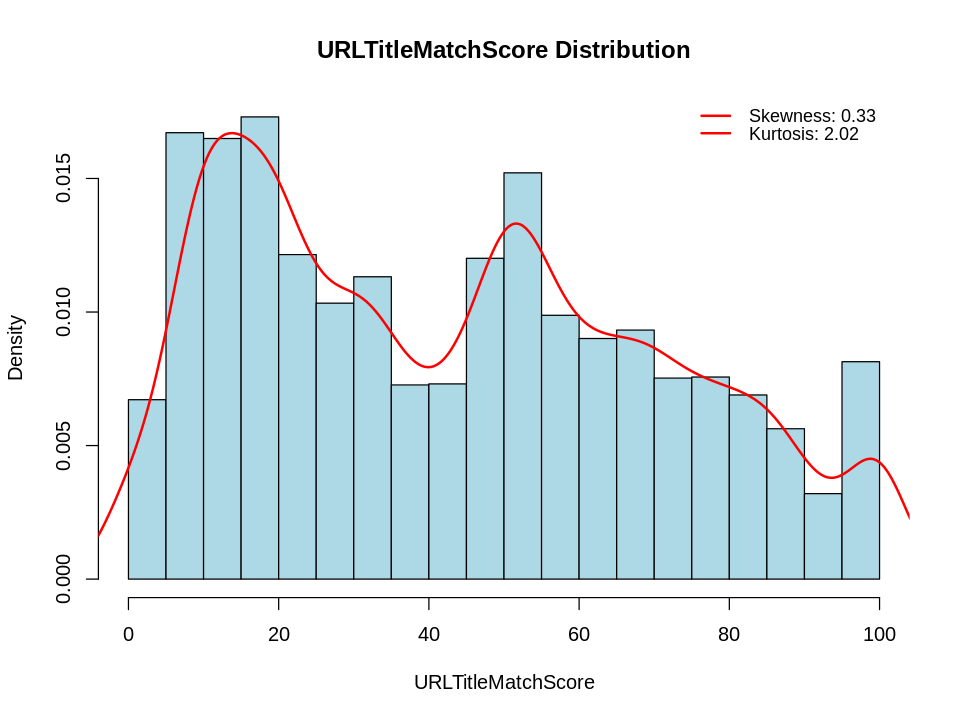

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

dens <- density(df$URLTitleMatchScore)

hist(df$URLTitleMatchScore,
     main = "URLTitleMatchScore Distribution",
     xlab = "URLTitleMatchScore",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
    )

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$URLTitleMatchScore)
kurtosis_value <- kurtosis(df$URLTitleMatchScore)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

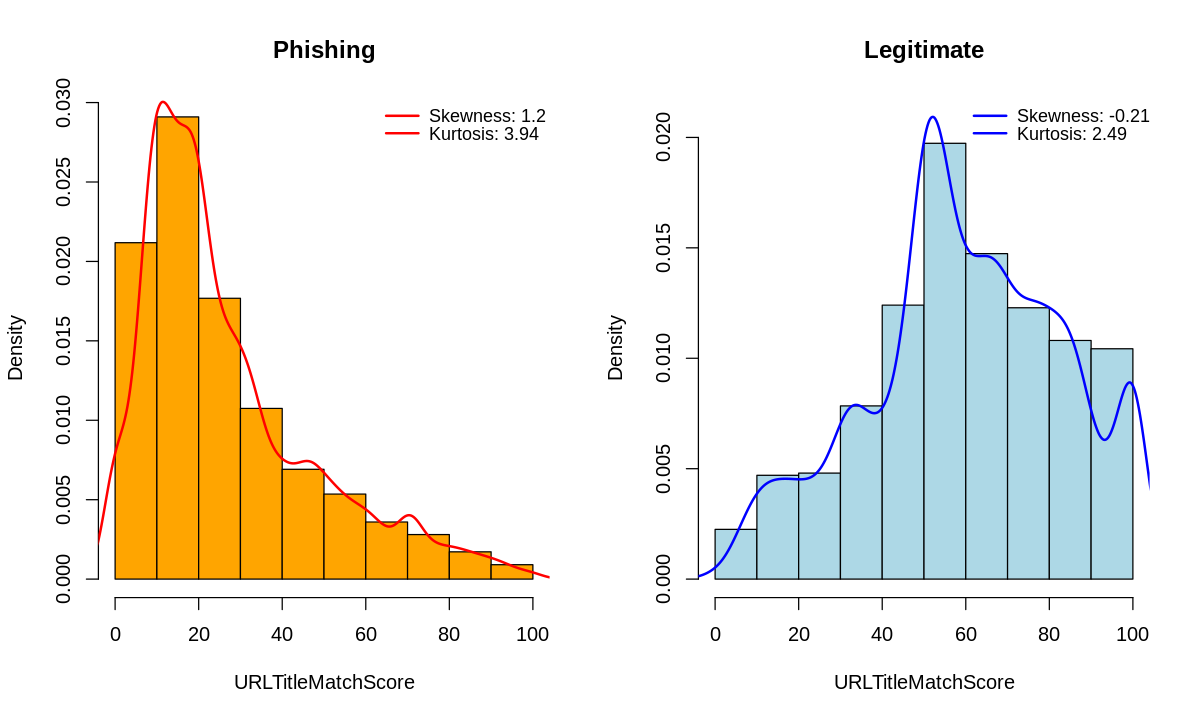

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

dens_0 <- density(df_0$URLTitleMatchScore)
dens_1 <- density(df_1$URLTitleMatchScore)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$URLTitleMatchScore)
kurtosis_value_0 <- kurtosis(df_0$URLTitleMatchScore)

skw_value_1 <- skewness(df_1$URLTitleMatchScore)
kurtosis_value_1 <- kurtosis(df_1$URLTitleMatchScore)

par(mfrow = c(1, 2))

# Phishing
hist(df_0$URLTitleMatchScore,
     main = "Phishing",
     xlab = "URLTitleMatchScore",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     )

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$URLTitleMatchScore,
     main = "Legitimate",
     xlab = "URLTitleMatchScore",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_1$y)))

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.25, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

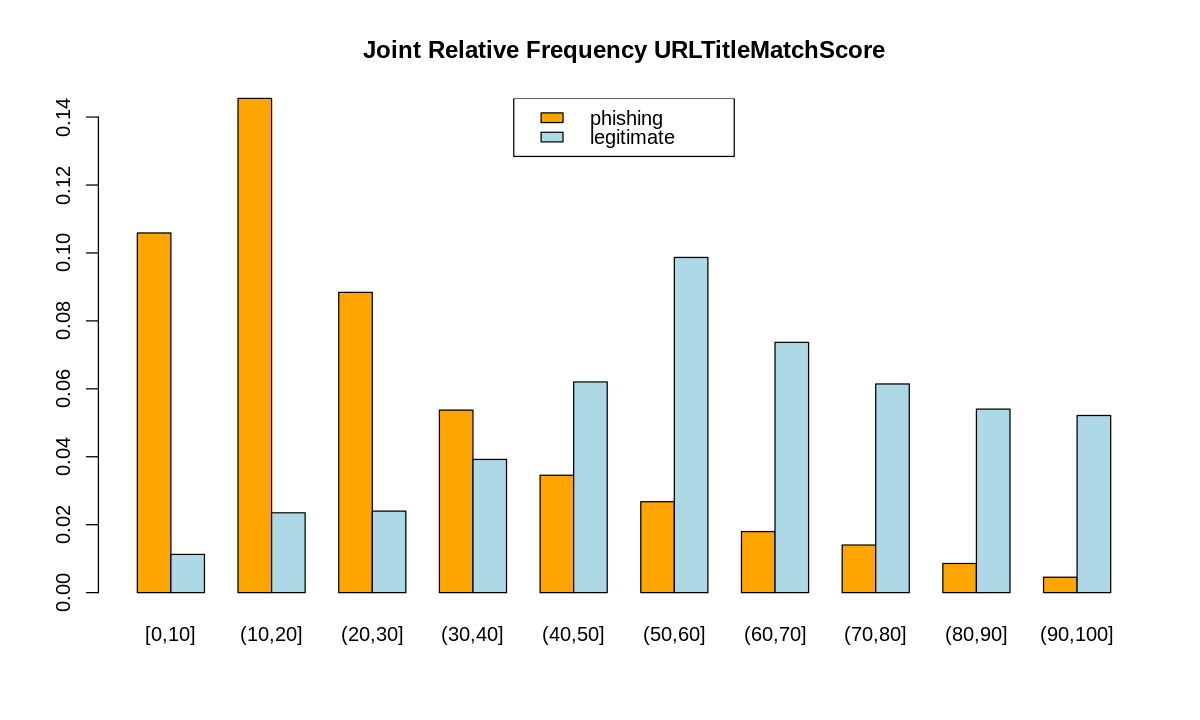

In [ ]:
breaks <- c(-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)

labels <- c("[0,10]", "(10,20]", "(20,30]", "(30,40]", "(40,50]", "(50,60]",
            "(60,70]", "(70,80]", "(80,90]","(90,100]")

j_freq <- table(df$label, cut(df$URLTitleMatchScore, breaks = breaks,
                              labels = labels))
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency URLTitleMatchScore", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$URLTitleMatchScore)
summary(df_1$URLTitleMatchScore)

outliers <- count_outliers(df, "URLTitleMatchScore")
outliers_0 <- count_outliers(df_0, "URLTitleMatchScore")
outliers_1 <- count_outliers(df_1, "URLTitleMatchScore")

cat('\nn. outliers URLTitleMatchScore: \t', outliers)
cat('\nn. outliers URLTitleMatchScore (0): \t', outliers_0)
cat('\nn. outliers URLTitleMatchScore (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   12.00   20.00   26.82   36.00  100.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   47.00   59.50   59.78   77.00  100.00 


n. outliers URLTitleMatchScore: 	 0
n. outliers URLTitleMatchScore (0): 	 218
n. outliers URLTitleMatchScore (1): 	 8

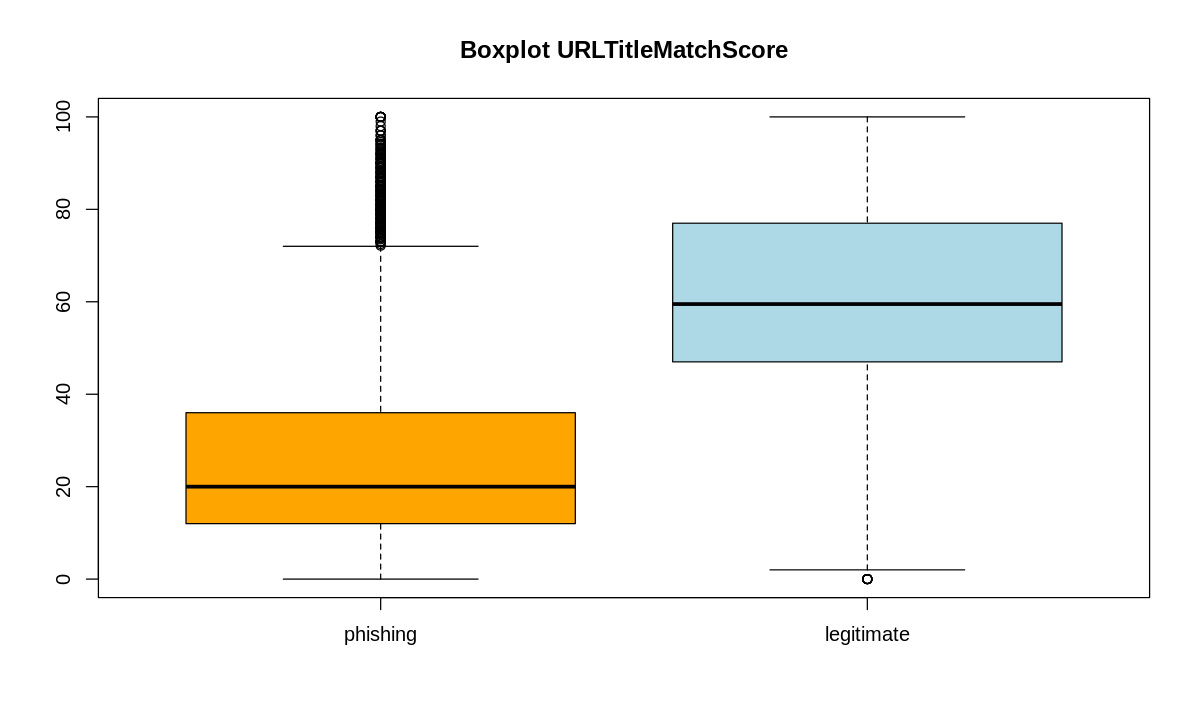

In [ ]:
boxplot(df_0$URLTitleMatchScore, df_1$URLTitleMatchScore,
        main = 'Boxplot URLTitleMatchScore', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "URLTitleMatchScore")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 19.4704 M2 = 20.5296 
Overlap df_1: M1 = 58.838 M2 = 60.162 


#### Correlation with label

In [ ]:
pearson <- cor(df$URLTitleMatchScore, df$label)
spearman <- cor(df$URLTitleMatchScore, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5975936
Spearman: 	 0.6034652

### 7. Feature **DomainTitleMatchScore**

In [ ]:
# dispersion
summary(df$DomainTitleMatchScore)

cat('\nvar: ', var(df$DomainTitleMatchScore), '\n')
cat('std: ', sd(df$DomainTitleMatchScore))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   16.00   44.20   45.11   67.00  100.00 


var:  888.4861 
std:  29.80748

#### Distribution form

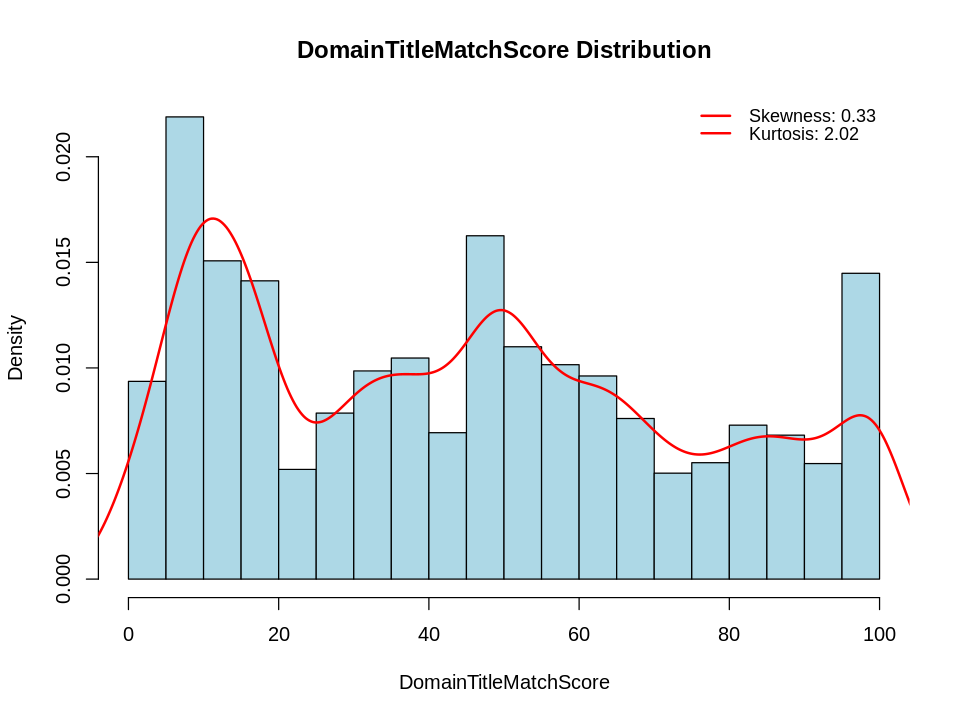

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

dens <- density(df$DomainTitleMatchScore)

hist(df$DomainTitleMatchScore,
     main = "DomainTitleMatchScore Distribution",
     xlab = "DomainTitleMatchScore",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
    )

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$URLTitleMatchScore)
kurtosis_value <- kurtosis(df$URLTitleMatchScore)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

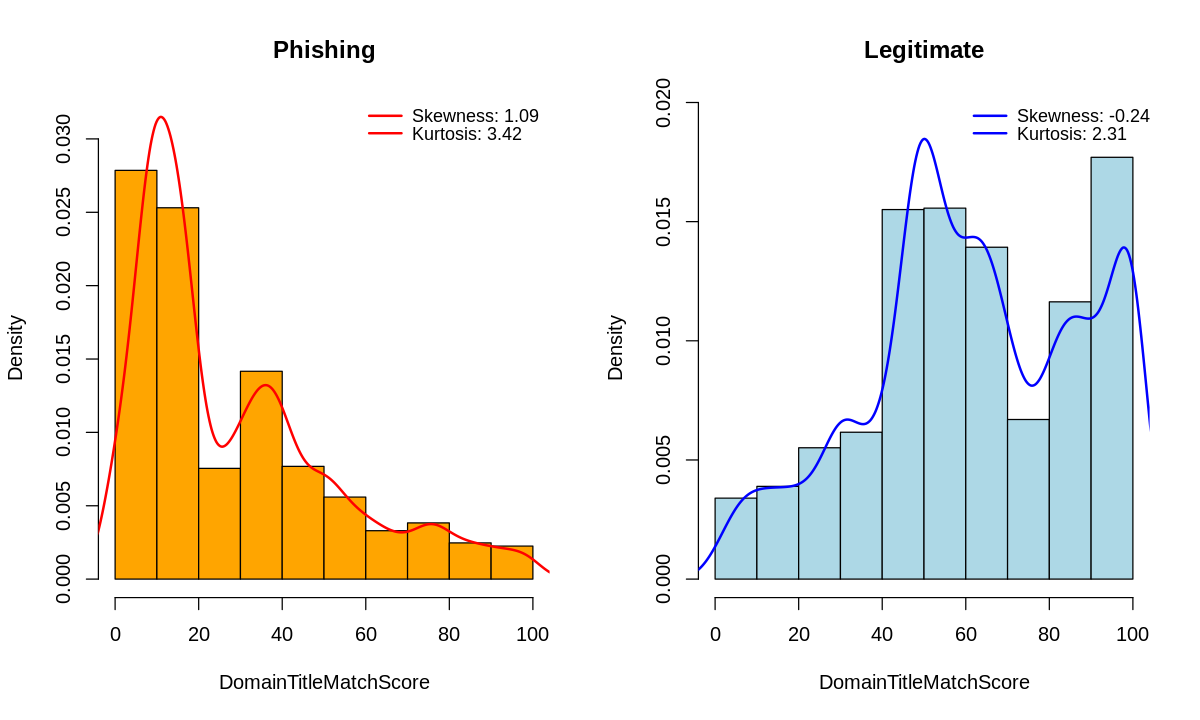

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

dens_0 <- density(df_0$DomainTitleMatchScore)
dens_1 <- density(df_1$DomainTitleMatchScore)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$DomainTitleMatchScore)
kurtosis_value_0 <- kurtosis(df_0$DomainTitleMatchScore)

skw_value_1 <- skewness(df_1$DomainTitleMatchScore)
kurtosis_value_1 <- kurtosis(df_1$DomainTitleMatchScore)

par(mfrow = c(1, 2))

# Phishing
hist(df_0$DomainTitleMatchScore,
     main = "Phishing",
     xlab = "DomainTitleMatchScore",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_0$y))
     )

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$DomainTitleMatchScore,
     main = "Legitimate",
     xlab = "DomainTitleMatchScore",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_1$y * 1.05)))

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.25, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

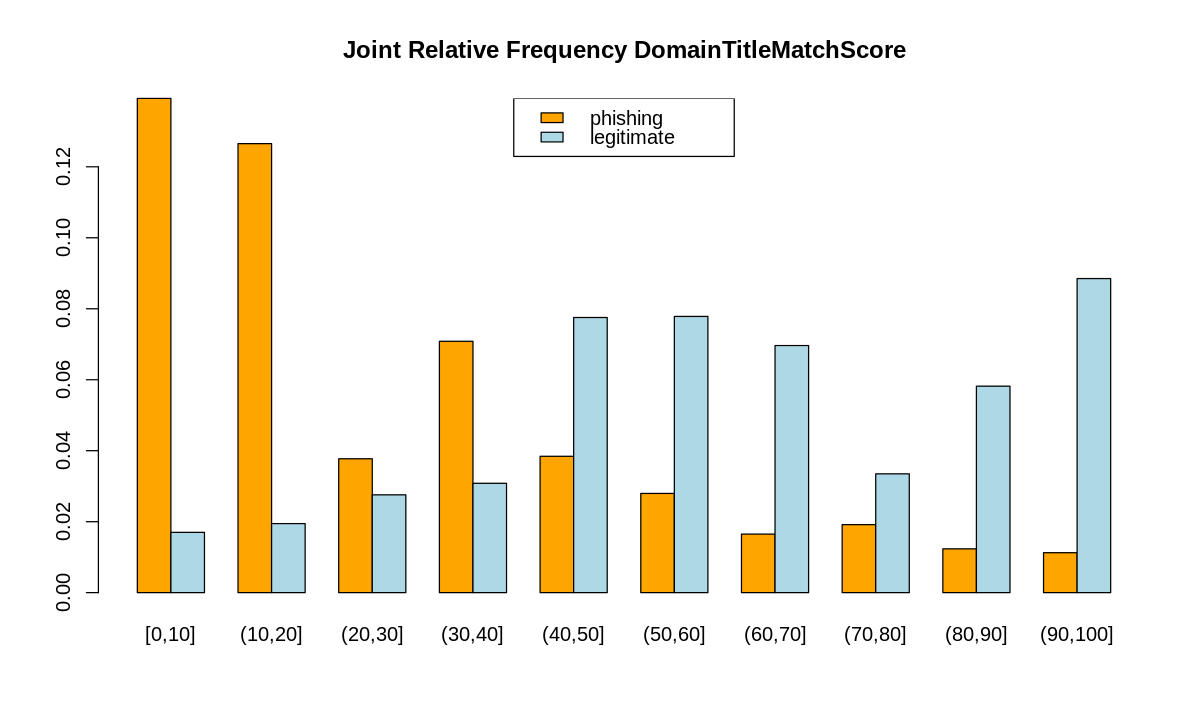

In [ ]:
breaks <- c(-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)

labels <- c("[0,10]", "(10,20]", "(20,30]", "(30,40]", "(40,50]", "(50,60]",
            "(60,70]", "(70,80]", "(80,90]","(90,100]")

j_freq <- table(df$label, cut(df$DomainTitleMatchScore, breaks = breaks,
                              labels = labels))
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency DomainTitleMatchScore", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$DomainTitleMatchScore)
summary(df_1$DomainTitleMatchScore)

outliers <- count_outliers(df, "DomainTitleMatchScore")
outliers_0 <- count_outliers(df_0, "DomainTitleMatchScore")
outliers_1 <- count_outliers(df_1, "DomainTitleMatchScore")

cat('\nn. outliers DomainTitleMatchScore: \t', outliers)
cat('\nn. outliers DomainTitleMatchScore (0): \t', outliers_0)
cat('\nn. outliers DomainTitleMatchScore (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   10.00   18.00   28.46   40.50  100.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   46.90   60.00   61.77   84.00  100.00 


n. outliers DomainTitleMatchScore: 	 0
n. outliers DomainTitleMatchScore (0): 	 157
n. outliers DomainTitleMatchScore (1): 	 0

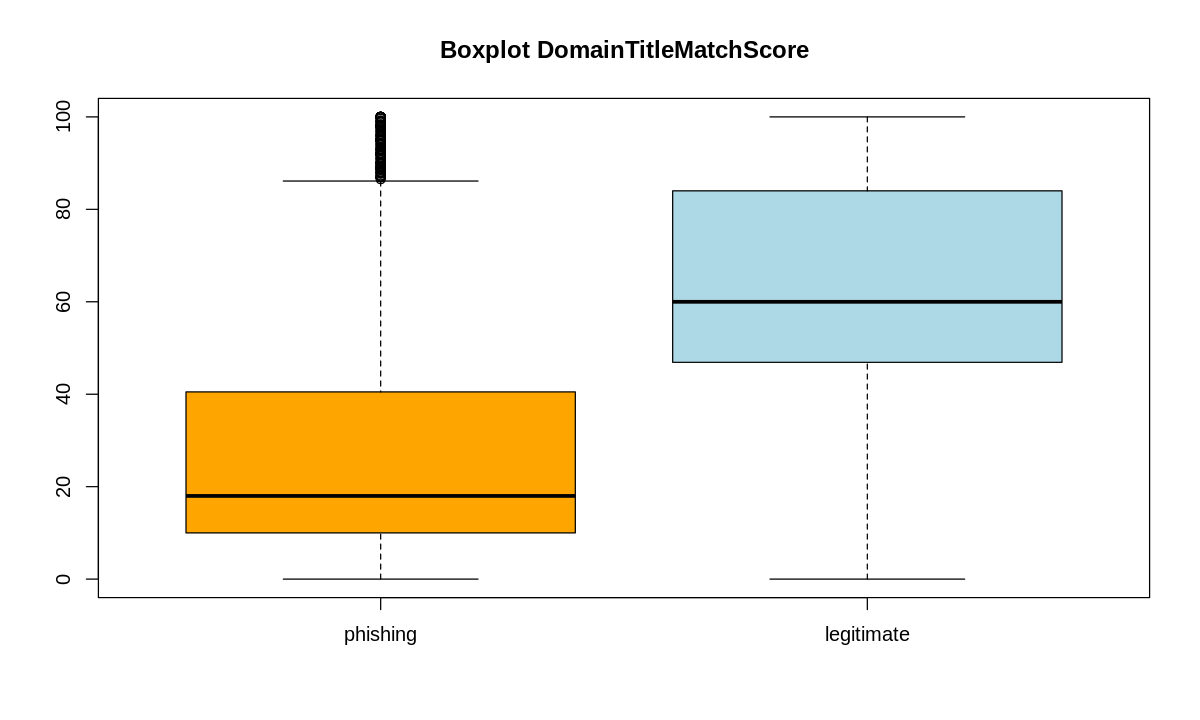

In [ ]:
boxplot(df_0$DomainTitleMatchScore, df_1$DomainTitleMatchScore,
        main = 'Boxplot DomainTitleMatchScore', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

#### Correlation with label

In [ ]:
pearson <- cor(df$DomainTitleMatchScore, df$label)
spearman <- cor(df$DomainTitleMatchScore, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.5587943
Spearman: 	 0.5660414

### 8. Feature **NoOfLettersInURL**


In [ ]:
# dispersion
summary(df$NoOfLettersInURL)

cat('\nvar: ', var(df$NoOfLettersInURL), '\n')
cat('std: ', sd(df$NoOfLettersInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   17.00   28.00   37.44   45.00  388.00 


var:  1160.819 
std:  34.07079

#### Distribution form

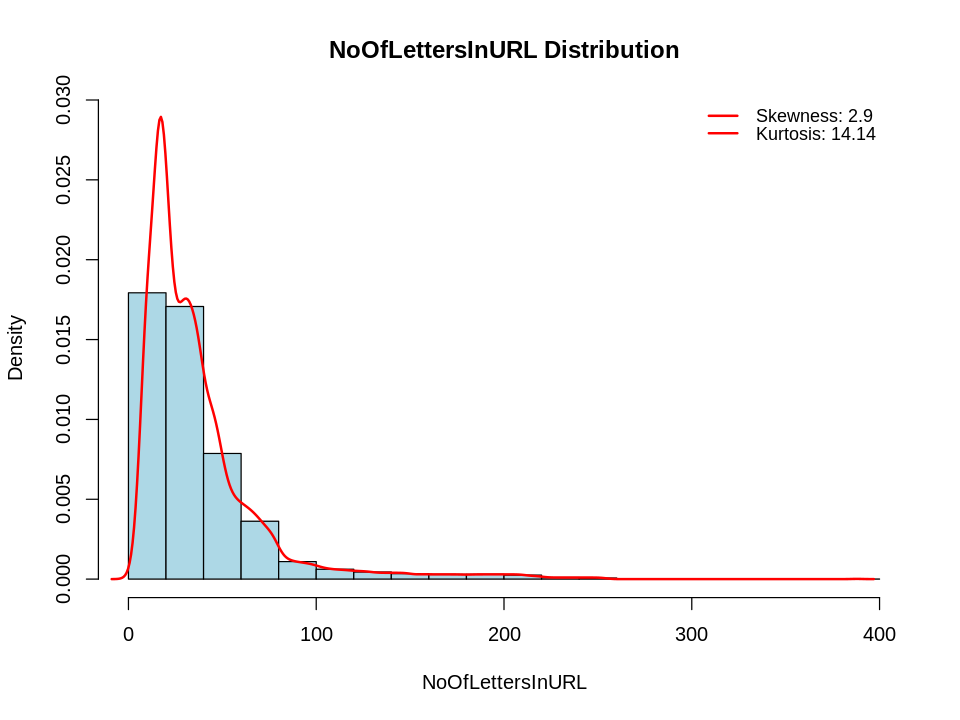

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

dens <- density(df$NoOfLettersInURL)

hist(df$NoOfLettersInURL,
     main = "NoOfLettersInURL Distribution",
     xlab = "NoOfLettersInURL",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens$y))
    )

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$NoOfLettersInURL)
kurtosis_value <- kurtosis(df$NoOfLettersInURL)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

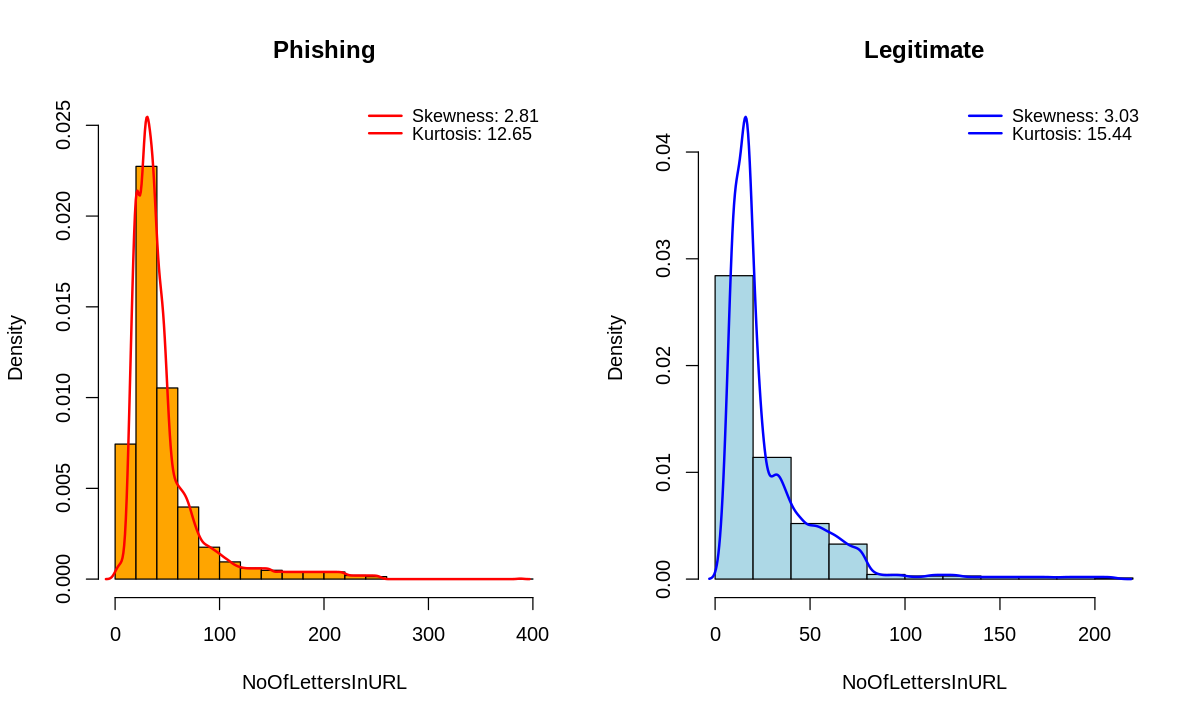

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

dens_0 <- density(df_0$NoOfLettersInURL)
dens_1 <- density(df_1$NoOfLettersInURL)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$NoOfLettersInURL)
kurtosis_value_0 <- kurtosis(df_0$NoOfLettersInURL)

skw_value_1 <- skewness(df_1$NoOfLettersInURL)
kurtosis_value_1 <- kurtosis(df_1$NoOfLettersInURL)

par(mfrow = c(1, 2))

# Phishing
hist(df_0$NoOfLettersInURL,
     main = "Phishing",
     xlab = "NoOfLettersInURL",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_0$y))
     )

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$NoOfLettersInURL,
     main = "Legitimate",
     xlab = "NoOfLettersInURL",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_1$y)))

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

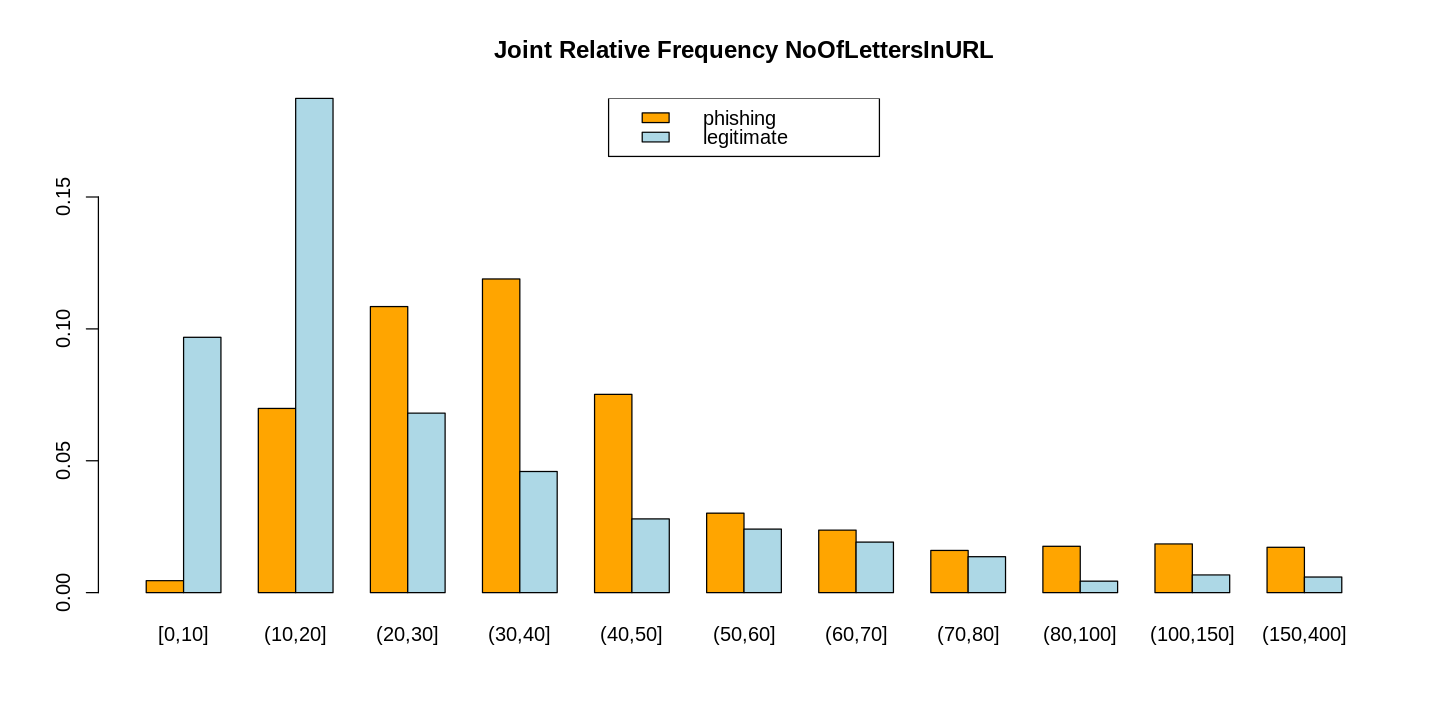

In [ ]:
breaks <- c(-1, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 400)

labels <- c("[0,10]", "(10,20]", "(20,30]", "(30,40]", "(40,50]", "(50,60]",
            "(60,70]", "(70,80]", "(80,100]", "(100,150]", "(150,400]")

j_freq <- table(df$label, cut(df$NoOfLettersInURL, breaks = breaks,
                              labels = labels))
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfLettersInURL", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfLettersInURL)
summary(df_1$NoOfLettersInURL)

outliers <- count_outliers(df, "NoOfLettersInURL")
outliers_0 <- count_outliers(df_0, "NoOfLettersInURL")
outliers_1 <- count_outliers(df_1, "NoOfLettersInURL")

cat('\nn. outliers NoOfLettersInURL: \t\t', outliers)
cat('\nn. outliers NoOfLettersInURL (0): \t', outliers_0)
cat('\nn. outliers NoOfLettersInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   26.00   36.00   46.41   50.00  388.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   13.00   18.00   28.48   35.00  211.00 


n. outliers NoOfLettersInURL: 		 624
n. outliers NoOfLettersInURL (0): 	 479
n. outliers NoOfLettersInURL (1): 	 343

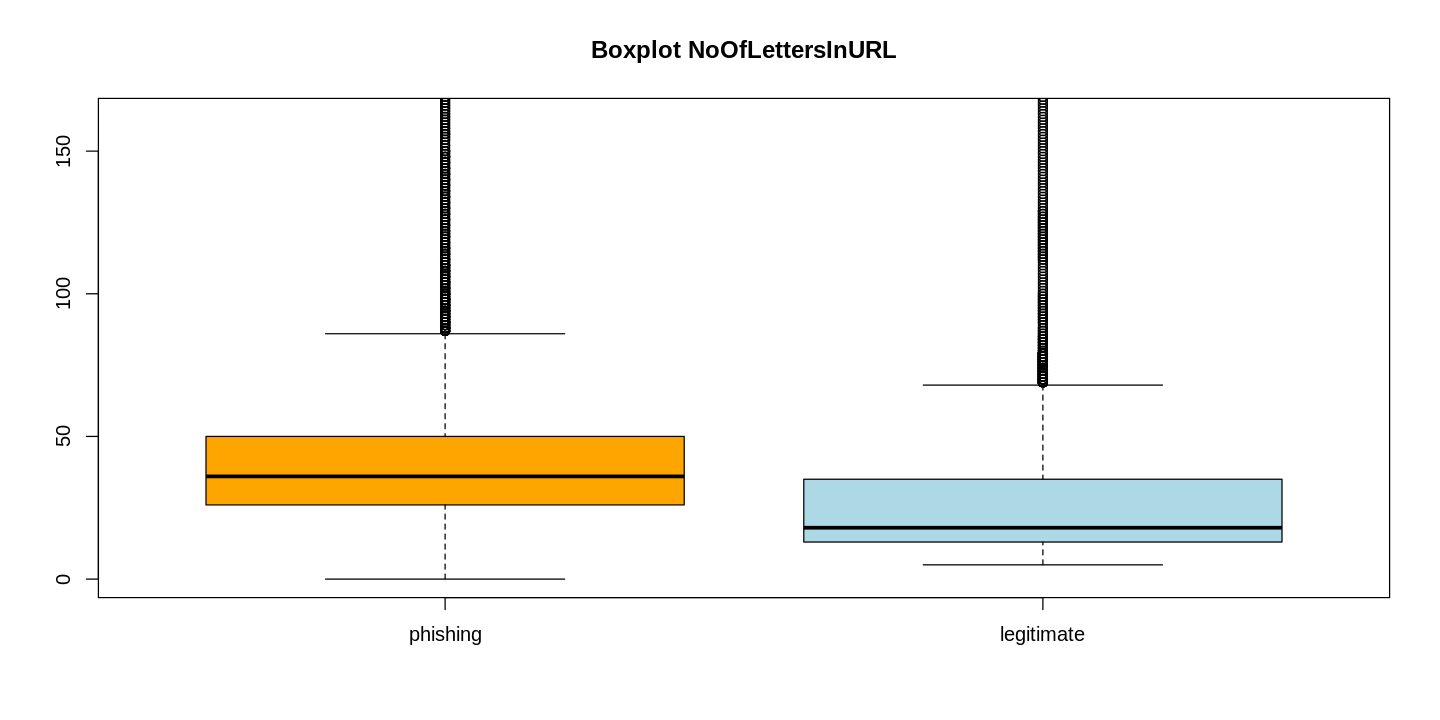

In [ ]:
boxplot(df_0$NoOfLettersInURL, df_1$NoOfLettersInURL,
        main = 'Boxplot NoOfLettersInURL', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfLettersInURL), quantile(df_0$NoOfLettersInURL, 0.97)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfLettersInURL")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 35.4704 M2 = 36.5296 
Overlap df_1: M1 = 17.51453 M2 = 18.48547 


#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfLettersInURL, df$label)
spearman <- cor(df$NoOfLettersInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.263073
Spearman: 	 -0.4115135

### 9. Feature **NoOfDigitsInURL**


In [ ]:
# dispersion
summary(df$NoOfDigitsInURL)

cat('\nvar: ', var(df$NoOfDigitsInURL), '\n')
cat('std: ', sd(df$NoOfDigitsInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   2.000   9.179   6.000 254.000 


var:  613.0545 
std:  24.75994

#### Distribution form

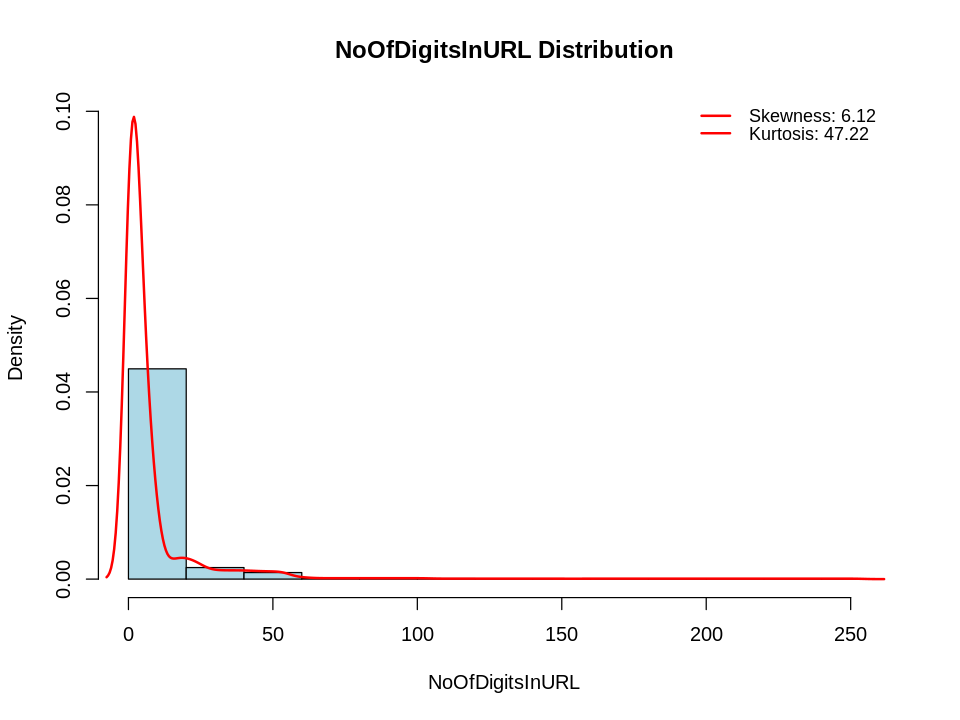

In [9]:
options(repr.plot.width = 8, repr.plot.height = 6)

n <- length(df$NoOfDigitsInURL)
h_sturges <- (max(df$NoOfDigitsInURL) - min(df$NoOfDigitsInURL)) / sqrt(n)
dens <- density(df$NoOfDigitsInURL, bw = h_sturges)

hist(df$NoOfDigitsInURL,
     main = "NoOfDigitsInURL Distribution",
     xlab = "NoOfDigitsInURL",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens$y)))

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$NoOfDigitsInURL)
kurtosis_value <- kurtosis(df$NoOfDigitsInURL)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

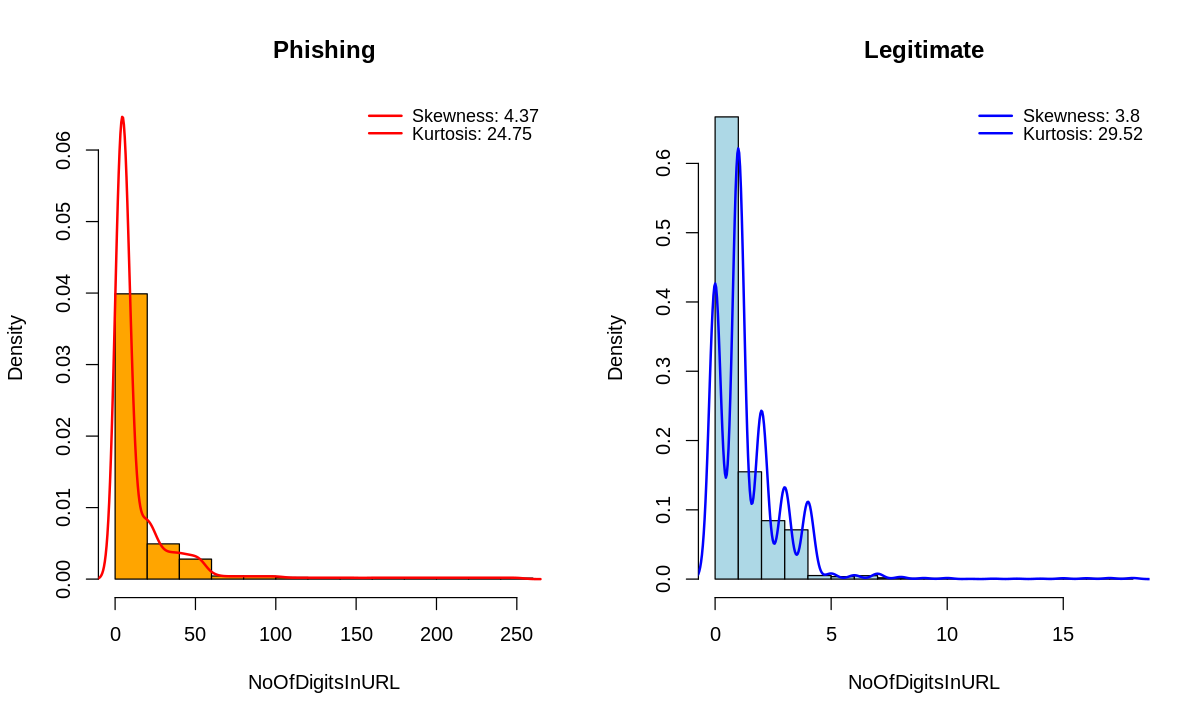

In [11]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Sturges rule
n_0 <- length(df_0$NoOfDigitsInURL)
h_sturges_0 <- (max(df_0$NoOfDigitsInURL) - min(df_0$NoOfDigitsInURL)) / sqrt(n_0)
dens_0 <- density(df_0$NoOfDigitsInURL, bw = h_sturges_0)

n_1 <- length(df_1$NoOfDigitsInURL)
h_sturges_1 <- (max(df_1$NoOfDigitsInURL) - min(df_1$NoOfDigitsInURL)) / sqrt(n_1)
dens_1 <- density(df_1$NoOfDigitsInURL, bw = h_sturges_1)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$NoOfDigitsInURL)
kurtosis_value_0 <- kurtosis(df_0$NoOfDigitsInURL)

skw_value_1 <- skewness(df_1$NoOfDigitsInURL)
kurtosis_value_1 <- kurtosis(df_1$NoOfDigitsInURL)


par(mfrow = c(1, 2))

# Phishing
hist(df_0$NoOfDigitsInURL,
     main = "Phishing",
     xlab = "NoOfDigitsInURL",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_0$y)))

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$NoOfDigitsInURL,
     main = "Legitimate",
     xlab = "NoOfDigitsInURL",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     )

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

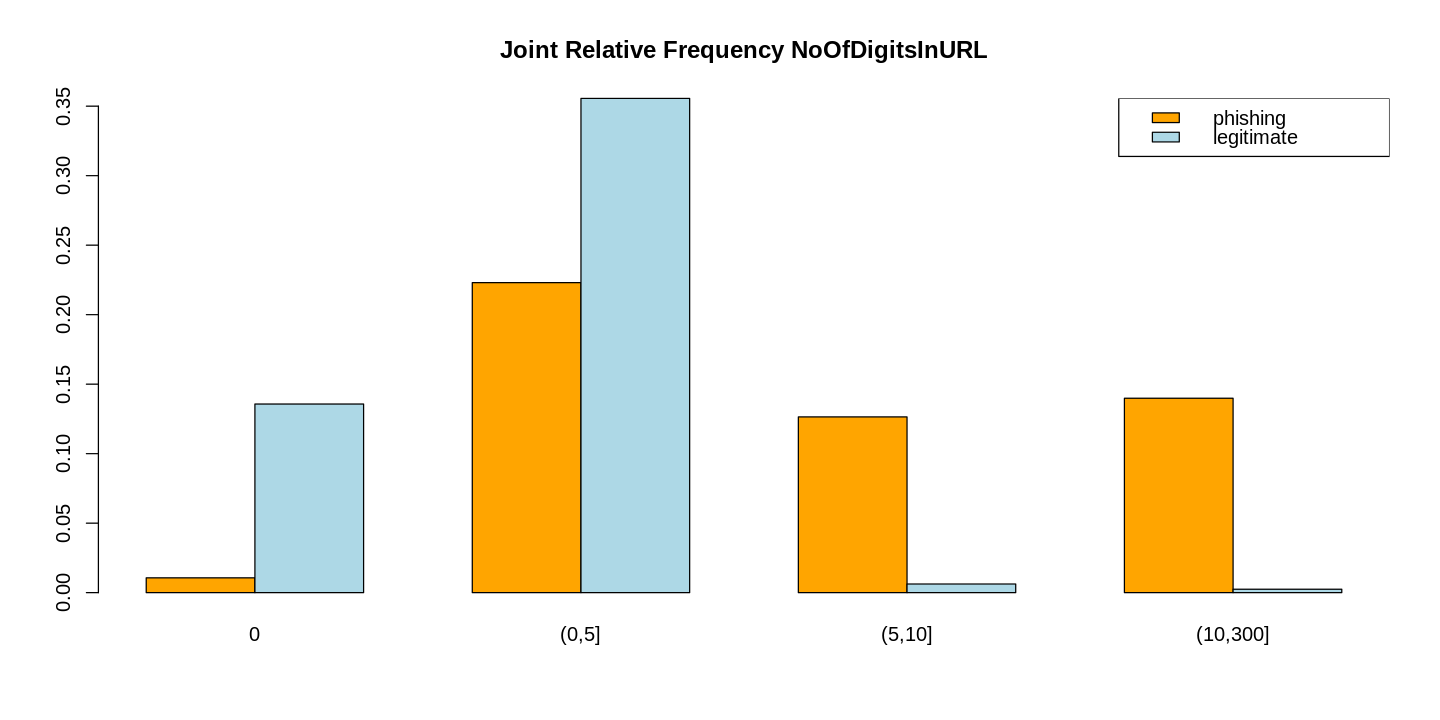

In [ ]:
breaks <- c(-1, 0, 5, 10, 300)

labels <- c("0", "(0,5]", "(5,10]", "(10,300]")

j_freq <- table(df$label, cut(df$NoOfDigitsInURL, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfDigitsInURL", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfDigitsInURL)
summary(df_1$NoOfDigitsInURL)

outliers <- count_outliers(df, "NoOfDigitsInURL")
outliers_0 <- count_outliers(df_0, "NoOfDigitsInURL")
outliers_1 <- count_outliers(df_1, "NoOfDigitsInURL")

cat('\nn. outliers NoOfDigitsInURL: \t\t', outliers)
cat('\nn. outliers NoOfDigitsInURL (0): \t', outliers_0)
cat('\nn. outliers NoOfDigitsInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    3.00    6.00   16.92   15.00  254.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   1.434   2.000  18.000 


n. outliers NoOfDigitsInURL: 		 1333
n. outliers NoOfDigitsInURL (0): 	 657
n. outliers NoOfDigitsInURL (1): 	 88

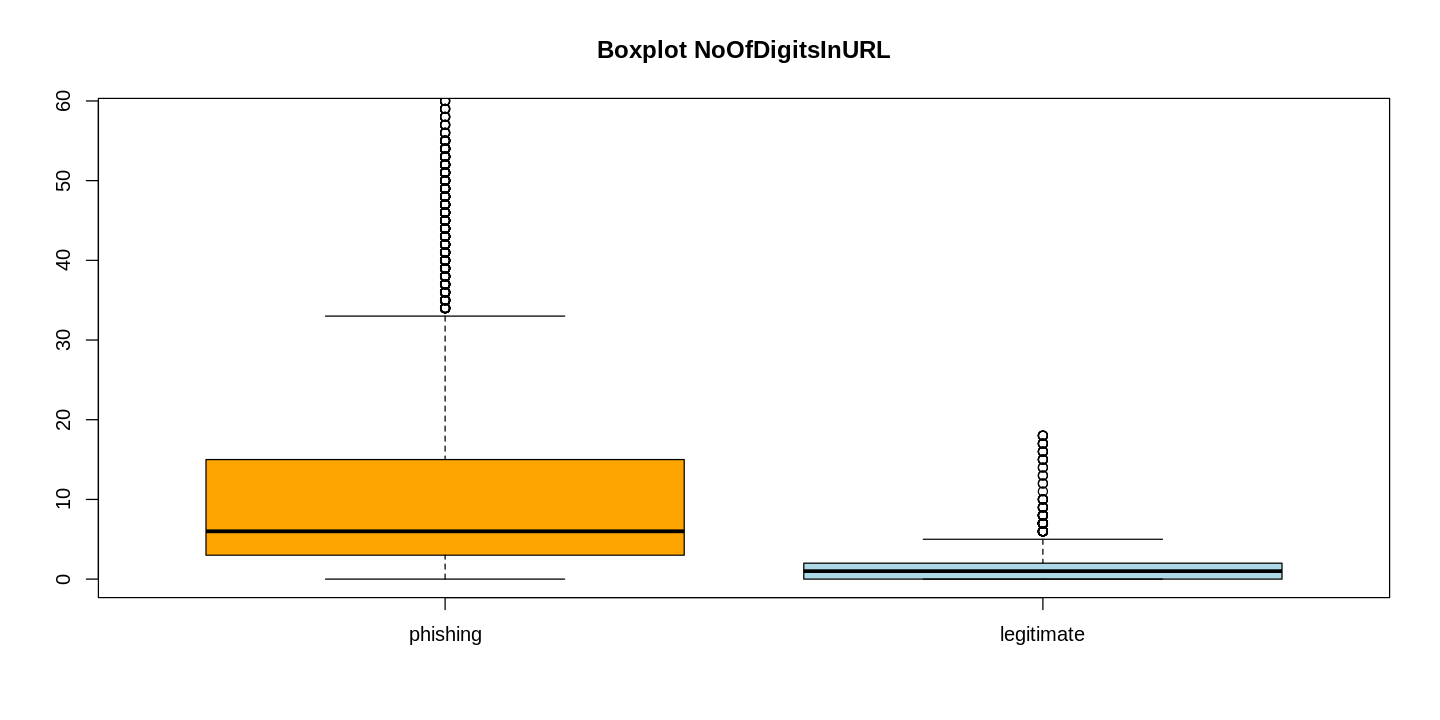

In [ ]:
boxplot(df_0$NoOfDigitsInURL, df_1$NoOfDigitsInURL,
        main = 'Boxplot NoOfDigitsInURL', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfDigitsInURL), quantile(df_0$NoOfDigitsInURL, 0.95)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfDigitsInURL")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 5.735199 M2 = 6.264801 
Overlap df_1: M1 = 0.9558665 M2 = 1.044134 


#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfDigitsInURL, df$label)
spearman <- cor(df$NoOfDigitsInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.3128256
Spearman: 	 -0.7121725

### 10. Feature **NoOfSpecialCharsInURL**

In [ ]:
# dispersion
summary(df$NoOfSpecialCharsInURL)

cat('\nvar: ', var(df$NoOfSpecialCharsInURL), '\n')
cat('std: ', sd(df$NoOfSpecialCharsInURL))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   2.000   7.305   5.000 252.000 


var:  553.324 
std:  23.52284

#### Distribution form

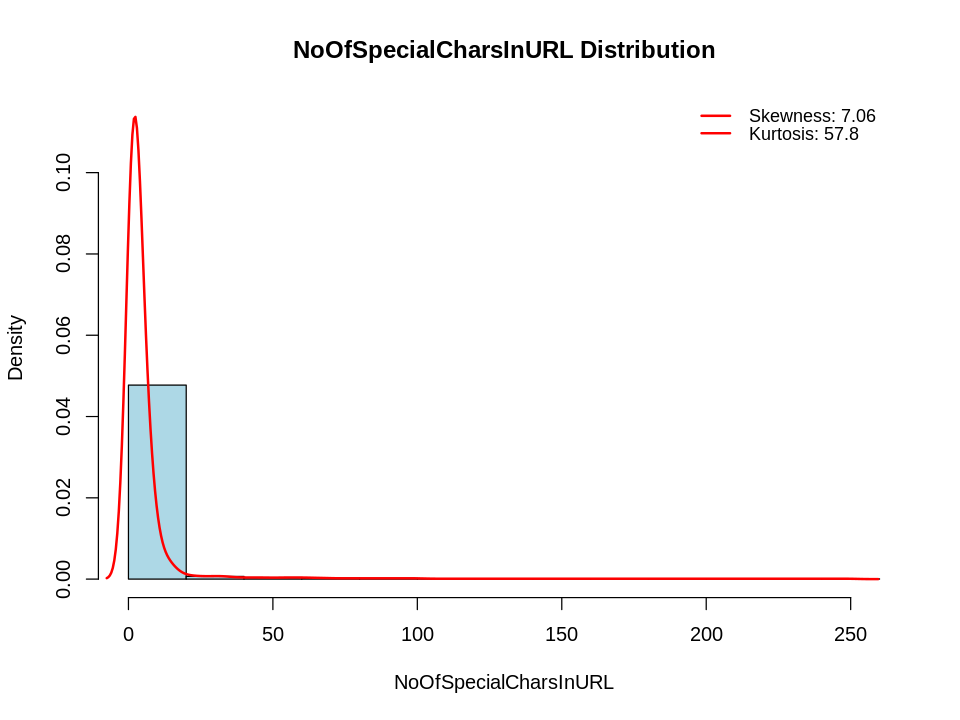

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

n <- length(df$NoOfSpecialCharsInURL)
h_sturges <- (max(df$NoOfSpecialCharsInURL) - min(df$NoOfSpecialCharsInURL)) / sqrt(n)
dens <- density(df$NoOfSpecialCharsInURL, bw = h_sturges)

hist(df$NoOfSpecialCharsInURL,
     main = "NoOfSpecialCharsInURL Distribution",
     xlab = "NoOfSpecialCharsInURL",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens$y))
    )

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$NoOfSpecialCharsInURL)
kurtosis_value <- kurtosis(df$NoOfSpecialCharsInURL)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

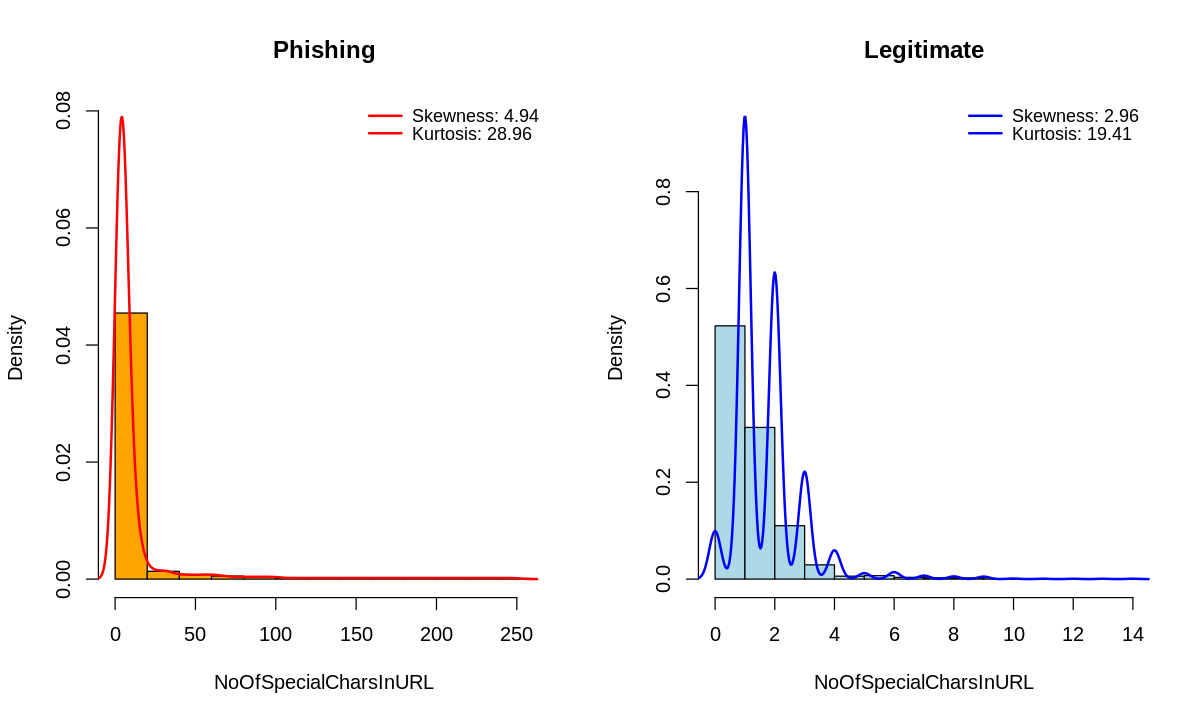

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Sturges rule
n_0 <- length(df_0$NoOfSpecialCharsInURL)
h_sturges_0 <- (max(df_0$NoOfSpecialCharsInURL) - min(df_0$NoOfSpecialCharsInURL)) / sqrt(n_0)
dens_0 <- density(df_0$NoOfSpecialCharsInURL, bw = h_sturges_0)

n_1 <- length(df_1$NoOfSpecialCharsInURL)
h_sturges_1 <- (max(df_1$NoOfSpecialCharsInURL) - min(df_1$NoOfSpecialCharsInURL)) / sqrt(n_1)
dens_1 <- density(df_1$NoOfSpecialCharsInURL, bw = h_sturges_1)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$NoOfSpecialCharsInURL)
kurtosis_value_0 <- kurtosis(df_0$NoOfSpecialCharsInURL)

skw_value_1 <- skewness(df_1$NoOfSpecialCharsInURL)
kurtosis_value_1 <- kurtosis(df_1$NoOfSpecialCharsInURL)

par(mfrow = c(1, 2))

# Phishing
hist(df_0$NoOfSpecialCharsInURL,
     main = "Phishing",
     xlab = "NoOfSpecialCharsInURL",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_0$y))
     )

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$NoOfSpecialCharsInURL,
     main = "Legitimate",
     xlab = "NoOfSpecialCharsInURL",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_1$y)))

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

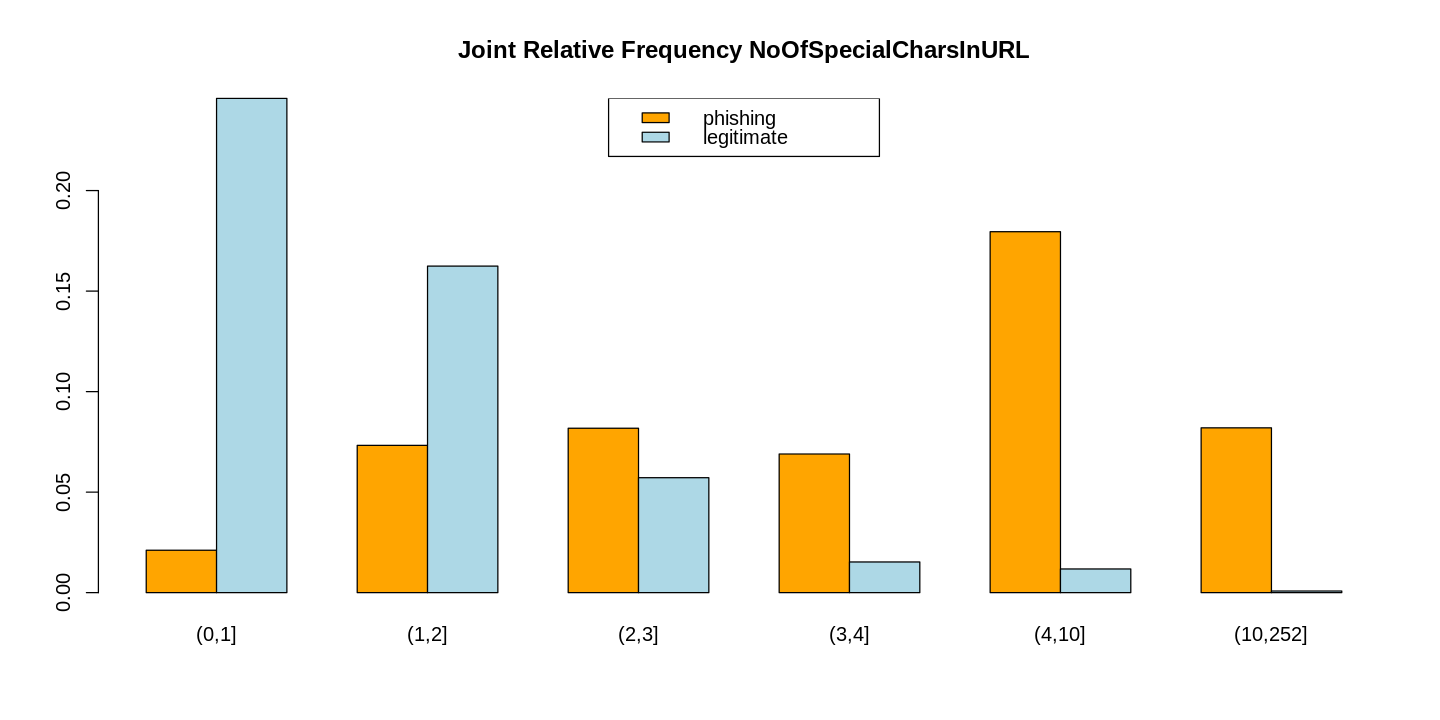

In [ ]:
breaks <- c(0, 1, 2, 3, 4, 10, 252)

labels <- c("(0,1]", "(1,2]", "(2,3]", "(3,4]", "(4,10]", "(10,252]")

j_freq <- table(df$label, cut(df$NoOfSpecialCharsInURL, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfSpecialCharsInURL", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfSpecialCharsInURL)
summary(df_1$NoOfSpecialCharsInURL)

outliers <- count_outliers(df, "NoOfSpecialCharsInURL")
outliers_0 <- count_outliers(df_0, "NoOfSpecialCharsInURL")
outliers_1 <- count_outliers(df_1, "NoOfSpecialCharsInURL")

cat('\nn. outliers NoOfSpecialCharsInURL: \t', outliers)
cat('\nn. outliers NoOfSpecialCharsInURL (0): \t', outliers_0)
cat('\nn. outliers NoOfSpecialCharsInURL (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    3.00    5.00   12.89    7.00  252.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   1.718   2.000  14.000 


n. outliers NoOfSpecialCharsInURL: 	 762
n. outliers NoOfSpecialCharsInURL (0): 	 629
n. outliers NoOfSpecialCharsInURL (1): 	 272

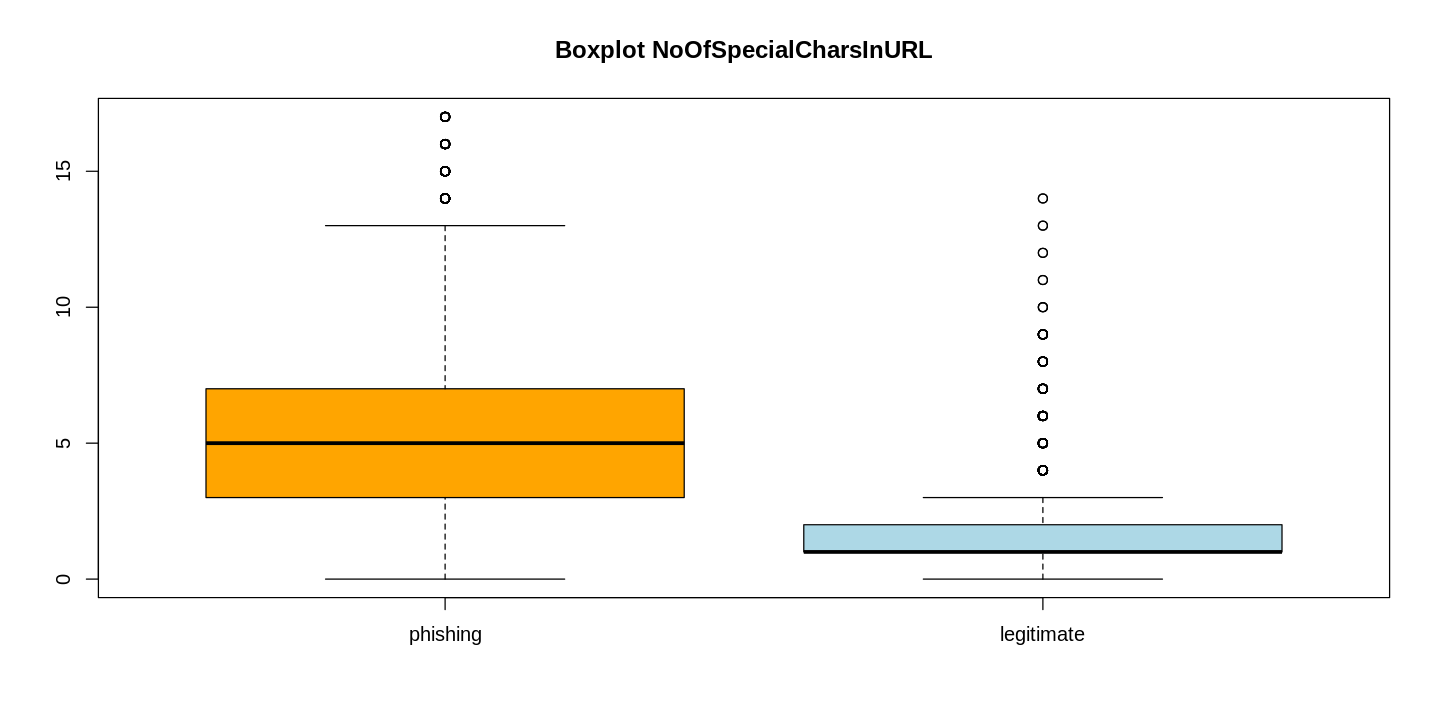

In [ ]:
boxplot(df_0$NoOfSpecialCharsInURL, df_1$NoOfSpecialCharsInURL,
        main = 'Boxplot NoOfSpecialCharsInURL', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfSpecialCharsInURL), quantile(df_0$NoOfSpecialCharsInURL, 0.90)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfSpecialCharsInURL")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 4.911733 M2 = 5.088267 
Overlap df_1: M1 = 0.9779332 M2 = 1.022067 


#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfSpecialCharsInURL, df$label)
spearman <- cor(df$NoOfSpecialCharsInURL, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 -0.2375306
Spearman: 	 -0.6622965

### 11. Feature **IsHTTPS**

#### Joint Relative Frequency

In [ ]:
# dispersion
summary(df$IsHTTPS)

cat('\nvar: ', var(df$IsHTTPS), '\n')
cat('std: ', sd(df$IsHTTPS))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.5772  1.0000  1.0000 


var:  0.2440577 
std:  0.494022

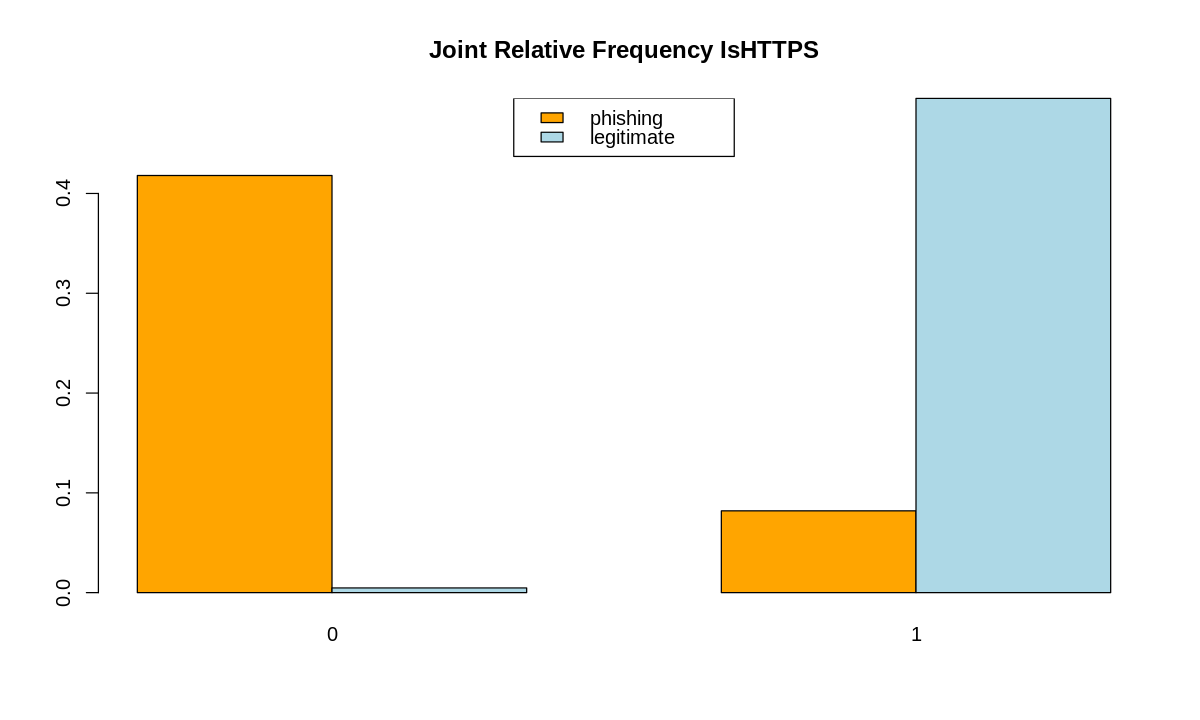

In [ ]:
j_freq <- table(df$label, df$IsHTTPS)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency IsHTTPS", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$IsHTTPS, df$label)
spearman <- cor(df$IsHTTPS, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.8365939
Spearman: 	 0.8365939

### 12. Feature **LineOfCode**

In [ ]:
# dispersion
summary(df$LineOfCode)

cat('\nvar: ', var(df$LineOfCode), '\n')
cat('std: ', sd(df$LineOfCode))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2     380     730    2000    1700   11570 


var:  8368176 
std:  2892.78

#### Distribution form

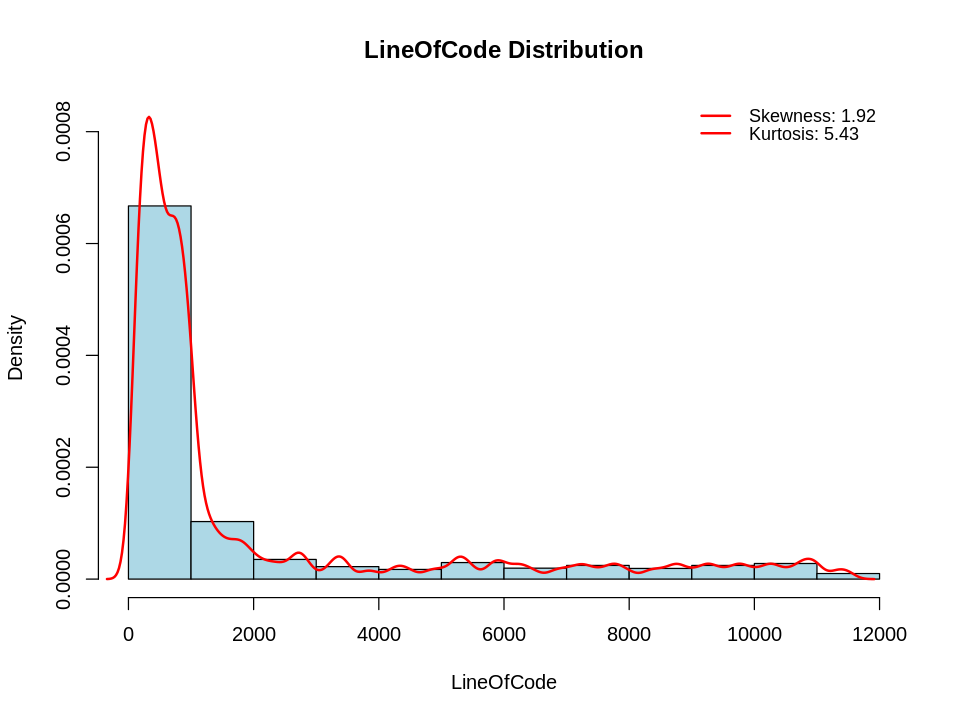

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

n <- length(df$LineOfCode)
h_sturges <- (max(df$LineOfCode) - min(df$LineOfCode)) / sqrt(n)
dens <- density(df$LineOfCode, bw = h_sturges)

hist(df$LineOfCode,
     main = "LineOfCode Distribution",
     xlab = "LineOfCode",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens$y))
    )

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$LineOfCode)
kurtosis_value <- kurtosis(df$LineOfCode)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

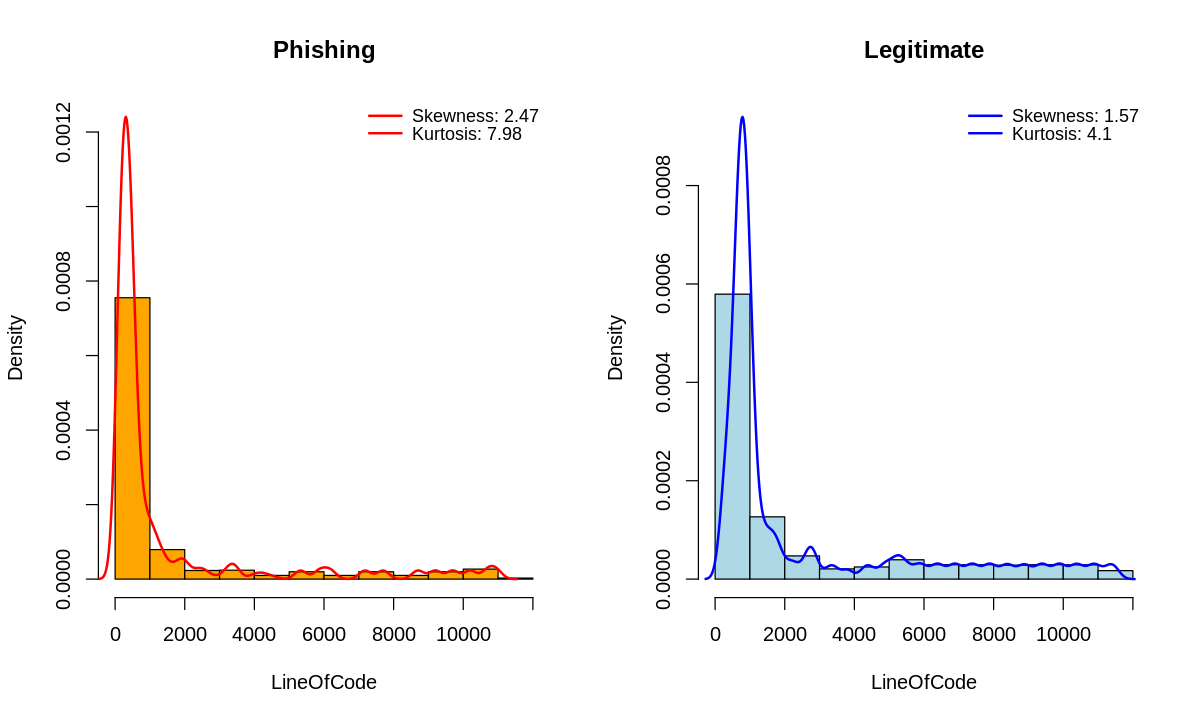

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Sturges rule
n_0 <- length(df_0$LineOfCode)
h_sturges_0 <- (max(df_0$LineOfCode) - min(df_0$LineOfCode)) / sqrt(n_0)
dens_0 <- density(df_0$LineOfCode, bw = h_sturges_0)

n_1 <- length(df_1$LineOfCode)
h_sturges_1 <- (max(df_1$LineOfCode) - min(df_1$LineOfCode)) / sqrt(n_1)
dens_1 <- density(df_1$LineOfCode, bw = h_sturges_1)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$LineOfCode)
kurtosis_value_0 <- kurtosis(df_0$LineOfCode)

skw_value_1 <- skewness(df_1$LineOfCode)
kurtosis_value_1 <- kurtosis(df_1$LineOfCode)

par(mfrow = c(1, 2))

# Phishing
hist(df_0$LineOfCode,
     main = "Phishing",
     xlab = "LineOfCode",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_0$y))
     )

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$LineOfCode,
     main = "Legitimate",
     xlab = "LineOfCode",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_1$y)))

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

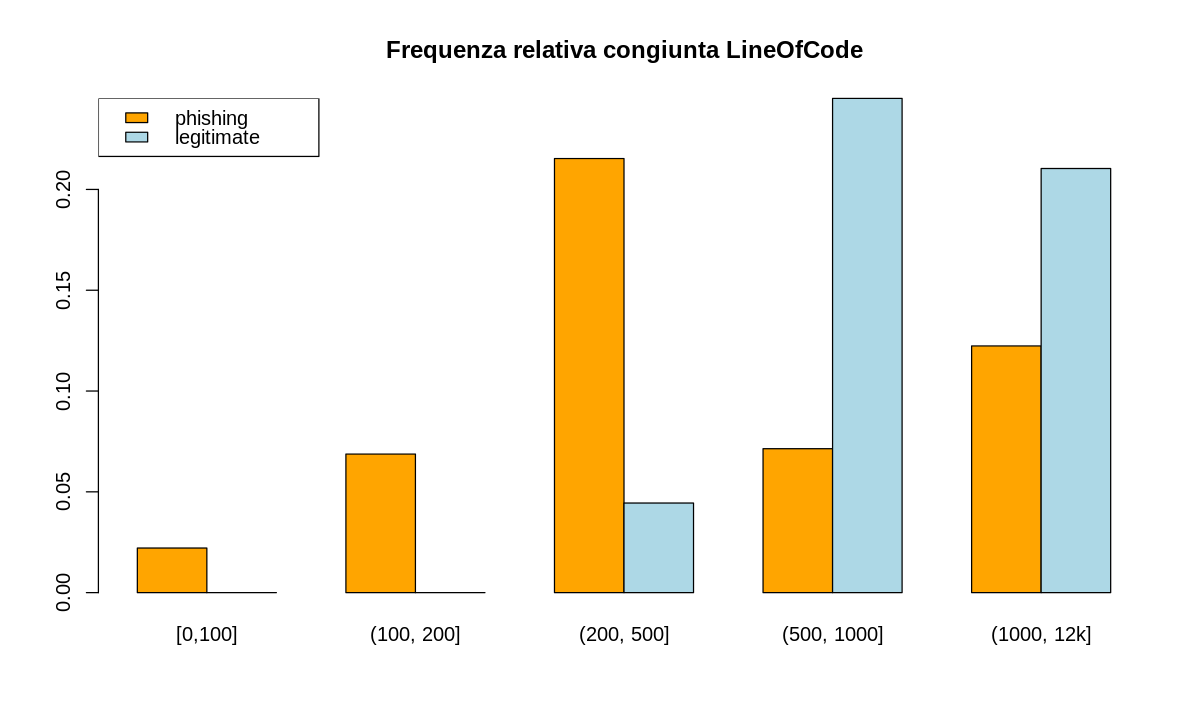

In [ ]:
breaks = c(-1, 100, 200, 500, 1000, 12000)

labels = c("[0,100]", "(100, 200]","(200, 500]", "(500, 1000]", "(1000, 12k]")

j_freq <- table(df$label, cut(df$LineOfCode, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Frequenza relativa congiunta LineOfCode", beside = TRUE)

legend("topleft", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$LineOfCode)
summary(df_1$LineOfCode)

outliers <- count_outliers(df, "LineOfCode")
outliers_0 <- count_outliers(df_0, "LineOfCode")
outliers_1 <- count_outliers(df_1, "LineOfCode")

cat('\nn. outliers LineOfCode: \t', outliers)
cat('\nn. outliers LineOfCode (0): \t', outliers_0)
cat('\nn. outliers LineOfCode (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0   236.2   412.0  1465.3   970.0 11070.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  205.0   700.2   930.0  2534.1  2888.8 11570.0 


n. outliers LineOfCode: 	 1795
n. outliers LineOfCode (0): 	 817
n. outliers LineOfCode (1): 	 807

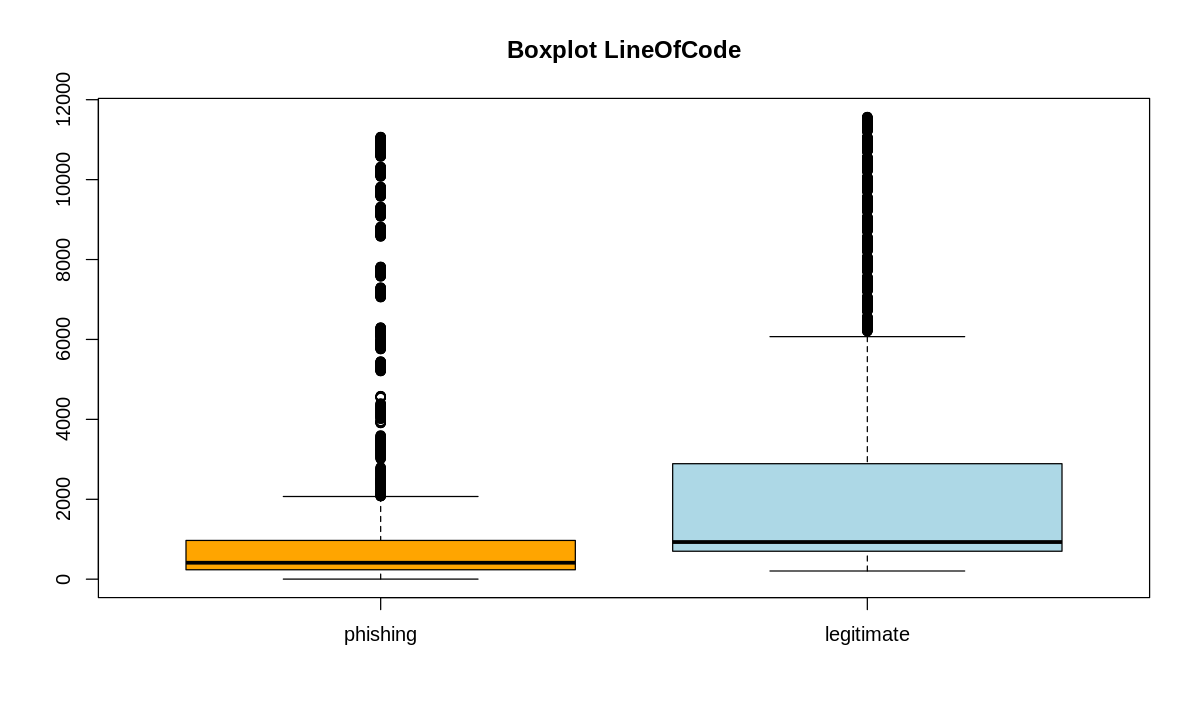

In [ ]:
boxplot(df_0$LineOfCode, df_1$LineOfCode,
        main = 'Boxplot LineOfCode', col = c('orange', 'lightblue'),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "LineOfCode")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 395.8085 M2 = 428.1915 
Overlap df_1: M1 = 881.7069 M2 = 978.2931 


#### Correlation with label

In [ ]:
pearson <- cor(df$LineOfCode, df$label)
spearman <- cor(df$LineOfCode, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.1847444
Spearman: 	 0.4353215

### 13. Feature **LargestLineLength**

In [ ]:
# dispersion
summary(df$LargestLineLength)

cat('\nvar: ', var(df$LargestLineLength), '\n')
cat('std: ', sd(df$LargestLineLength))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     23    1310    2350    7422    4100   46349 


var:  137165937 
std:  11711.79

#### Distribution form

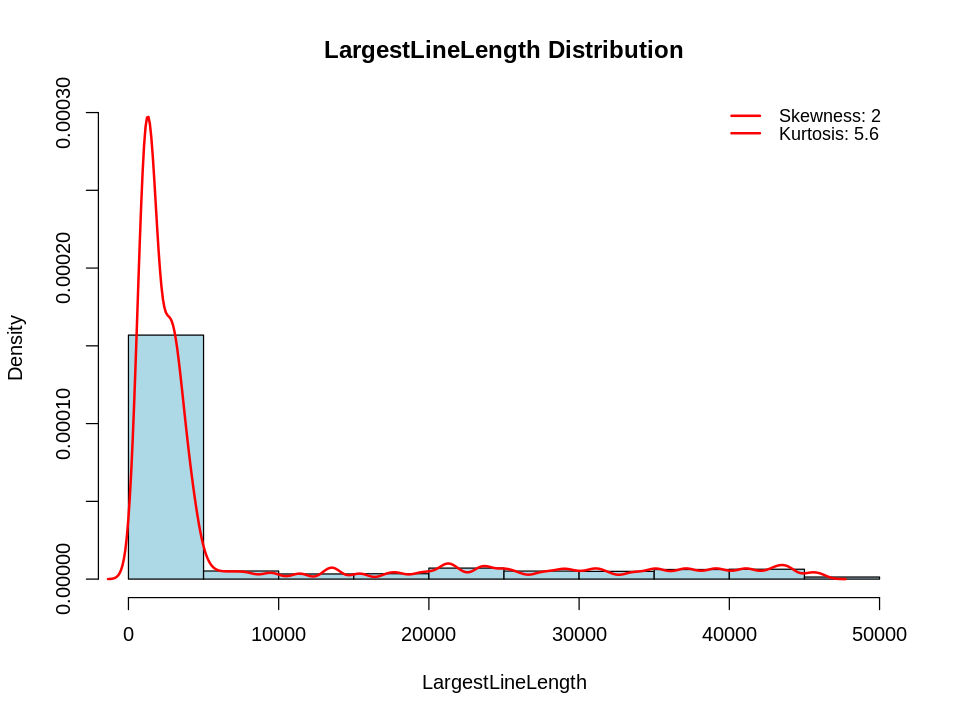

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

n <- length(df$LargestLineLength)
h_sturges <- (max(df$LargestLineLength) - min(df$LargestLineLength)) / sqrt(n)
dens <- density(df$LargestLineLength, bw = h_sturges)

hist(df$LargestLineLength,
     main = "LargestLineLength Distribution",
     xlab = "LargestLineLength",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens$y))
    )

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$LargestLineLength)
kurtosis_value <- kurtosis(df$LargestLineLength)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

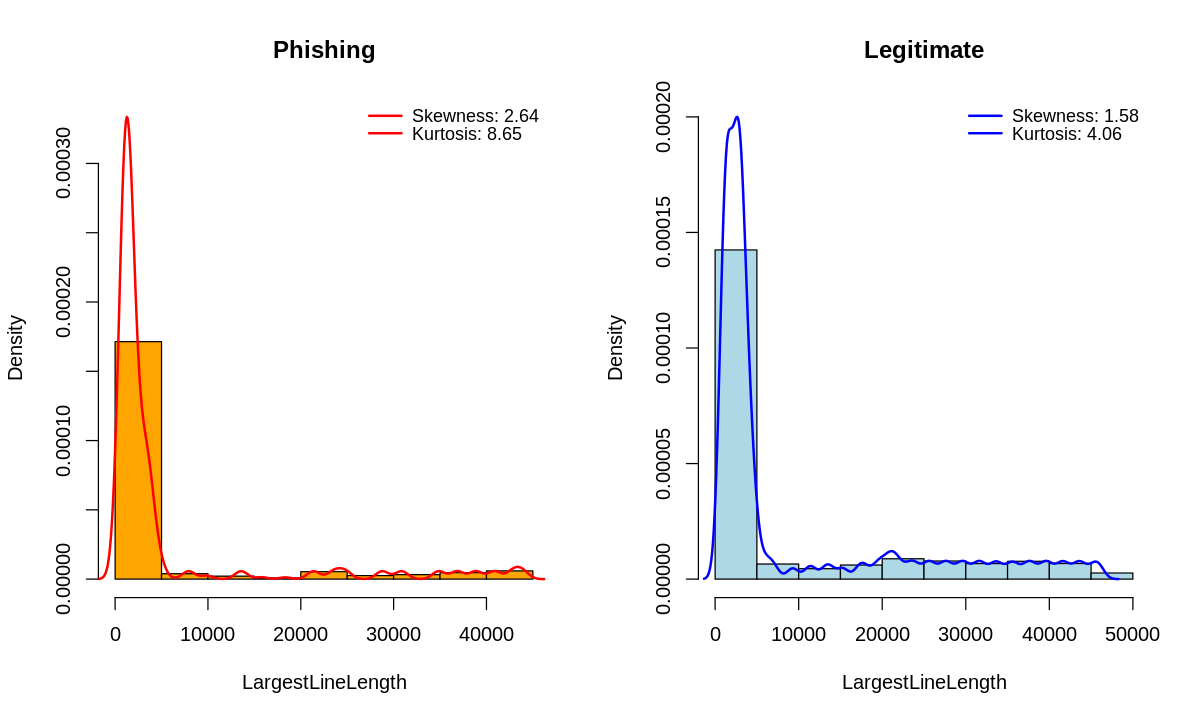

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Sturges rule
n_0 <- length(df_0$LargestLineLength)
h_sturges_0 <- (max(df_0$LargestLineLength) - min(df_0$LargestLineLength)) / sqrt(n_0)
dens_0 <- density(df_0$LargestLineLength, bw = h_sturges_0)

n_1 <- length(df_1$LargestLineLength)
h_sturges_1 <- (max(df_1$LargestLineLength) - min(df_1$LargestLineLength)) / sqrt(n_1)
dens_1 <- density(df_1$LargestLineLength, bw = h_sturges_1)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$LargestLineLength)
kurtosis_value_0 <- kurtosis(df_0$LargestLineLength)

skw_value_1 <- skewness(df_1$LargestLineLength)
kurtosis_value_1 <- kurtosis(df_1$LargestLineLength)

par(mfrow = c(1, 2))

# Phishing
hist(df_0$LargestLineLength,
     main = "Phishing",
     xlab = "LargestLineLength",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_0$y))
     )

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$LargestLineLength,
     main = "Legitimate",
     xlab = "LargestLineLength",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_1$y)))

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

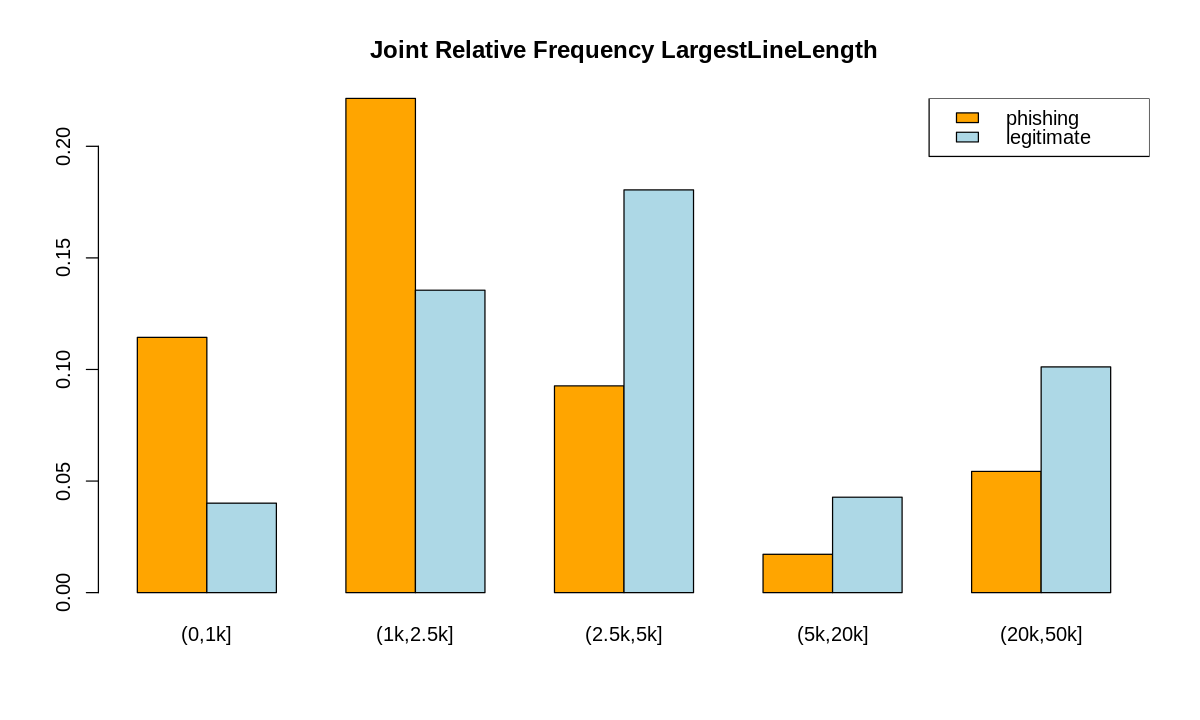

In [ ]:
breaks <- c(0, 1000, 2500, 5000, 20000, 50000)

labels <- c("(0,1k]", "(1k,2.5k]", "(2.5k,5k]", "(5k,20k]", "(20k,50k]")

j_freq <- table(df$label, cut(df$LargestLineLength, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency LargestLineLength", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$LargestLineLength)
summary(df_1$LargestLineLength)

outliers <- count_outliers(df, "LargestLineLength")
outliers_0 <- count_outliers(df_0, "LargestLineLength")
outliers_1 <- count_outliers(df_1, "LargestLineLength")

cat('\nn. outliers LargestLineLength: \t\t', outliers)
cat('\nn. outliers LargestLineLength (0): \t', outliers_0)
cat('\nn. outliers LargestLineLength (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     23    1060    1640    5481    3302   44349 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    600    1700    2900    9363   11424   46349 


n. outliers LargestLineLength: 		 1980
n. outliers LargestLineLength (0): 	 691
n. outliers LargestLineLength (1): 	 750

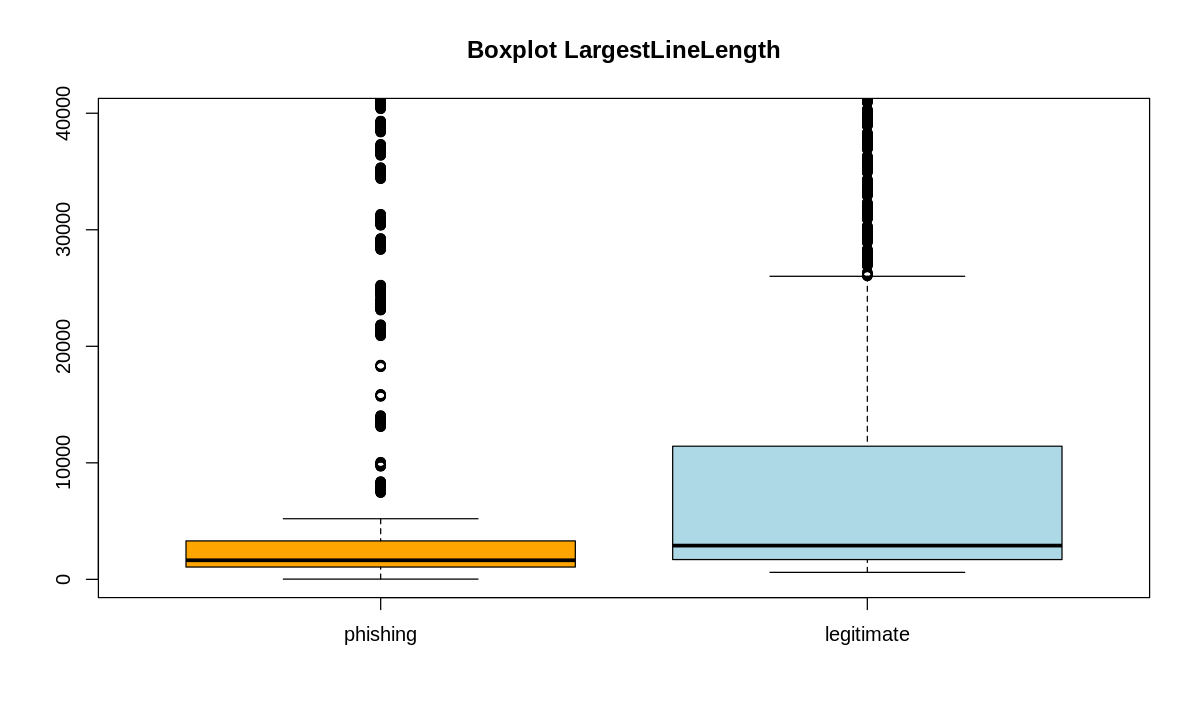

In [ ]:
boxplot(df_0$LargestLineLength, df_1$LargestLineLength,
        main = 'Boxplot LargestLineLength', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$LargestLineLength), quantile(df_1$LargestLineLength, 0.95)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "LargestLineLength")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 1590.537 M2 = 1689.463 
Overlap df_1: M1 = 2685.423 M2 = 3114.577 


#### Correlation with label

In [ ]:
pearson <- cor(df$LargestLineLength, df$label)
spearman <- cor(df$LargestLineLength, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.1657452
Spearman: 	 0.3022736

### 14. Feature **HasTitle**

In [ ]:
# dispersion
summary(df$HasTitle)

cat('\nvar: ', var(df$HasTitle), '\n')
cat('std: ', sd(df$HasTitle))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.6496  1.0000  1.0000 


var:  0.227629 
std:  0.4771048

#### Joint Relative Frequency

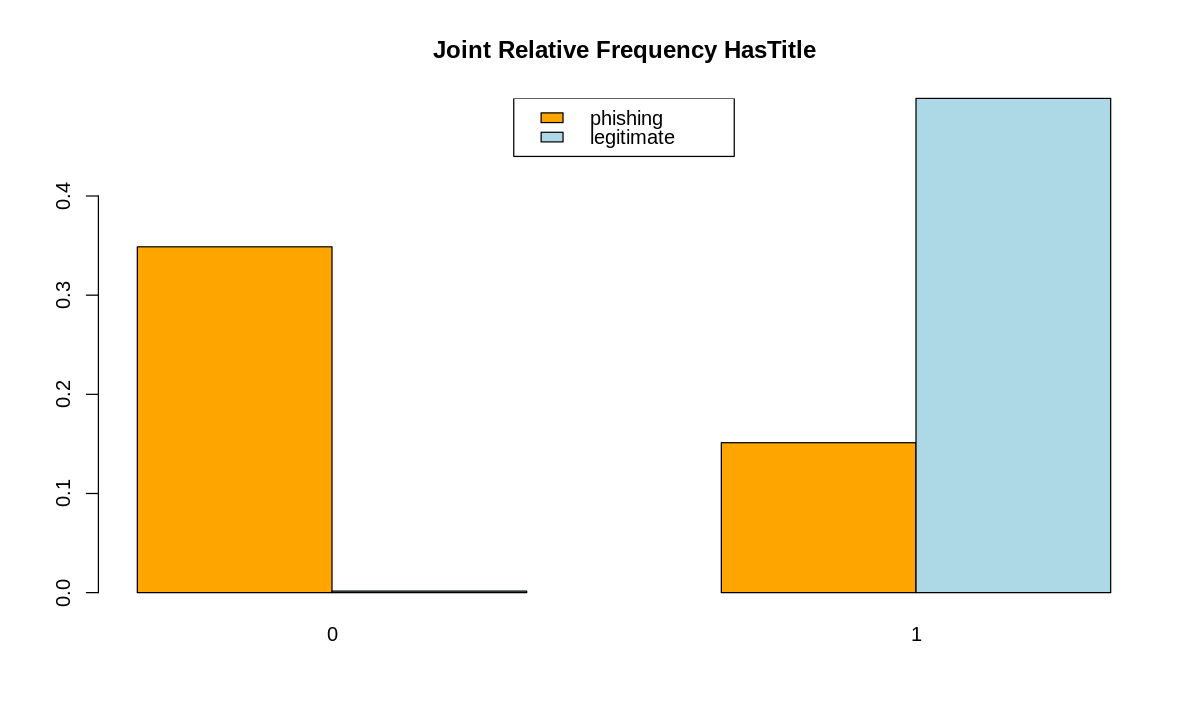

In [ ]:
j_freq <- table(df$label, df$HasTitle)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasTitle", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasTitle, df$label)
spearman <- cor(df$HasTitle, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.7277477
Spearman: 	 0.7277477

### 15. Feature **Robots**

In [ ]:
# dispersion
summary(df$Robots)

cat('\nvar: ', var(df$Robots), '\n')
cat('std: ', sd(df$Robots))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3919  1.0000  1.0000 


var:  0.2383466 
std:  0.4882075

#### Joint Relative Frequency

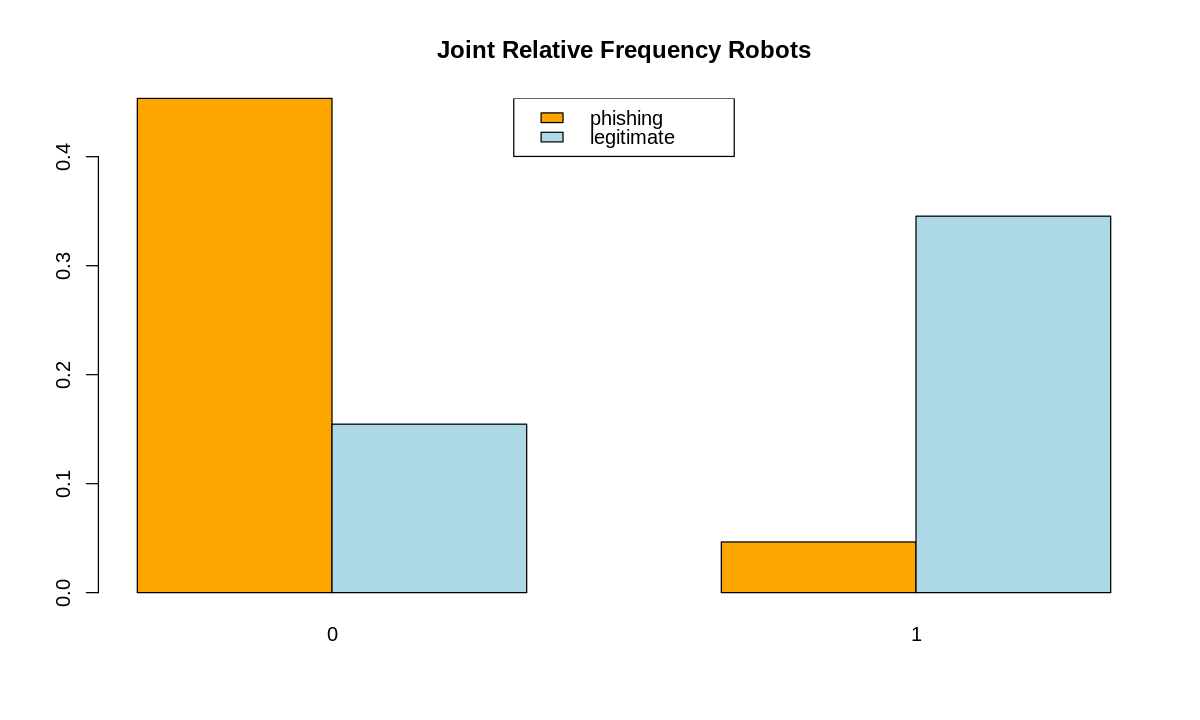

In [ ]:
j_freq <- table(df$label, df$Robots)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency Robots", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$Robots, df$label)
spearman <- cor(df$Robots, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.612257
Spearman: 	 0.612257

### 16. Feature **IsResponsive**

In [ ]:
# dispersion
summary(df$IsResponsive)

cat('\nvar: ', var(df$IsResponsive), '\n')
cat('std: ', sd(df$IsResponsive))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4919  1.0000  1.0000 


var:  0.2499591 
std:  0.4999591

#### Joint Relative Frequency

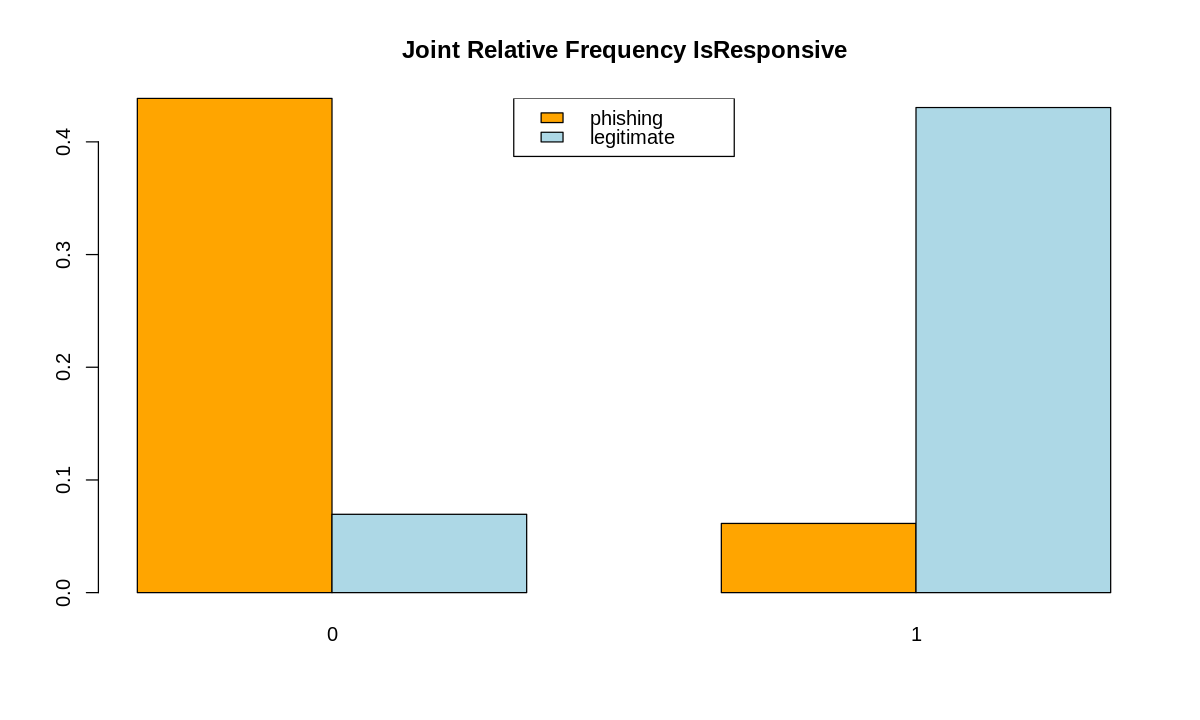

In [ ]:
j_freq <- table(df$label, df$IsResponsive)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency IsResponsive", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$IsResponsive, df$label)
spearman <- cor(df$IsResponsive, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.7381451
Spearman: 	 0.7381451

### 17. Feature **HasDescription**

In [ ]:
# dispersion
summary(df$HasDescription)

cat('\nvar: ', var(df$HasDescription), '\n')
cat('std: ', sd(df$HasDescription))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4149  1.0000  1.0000 


var:  0.2427744 
std:  0.4927215

#### Joint Relative Frequency

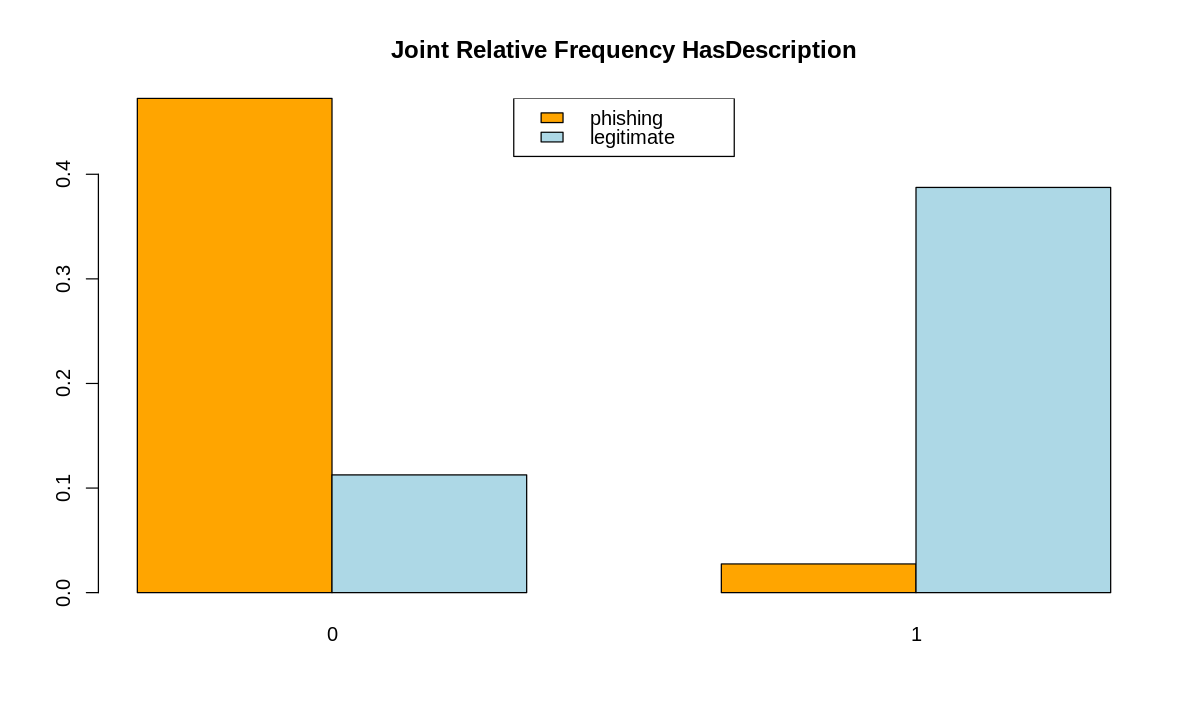

In [ ]:
j_freq <- table(df$label, df$HasDescription)
j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasDescription", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasDescription, df$label)
spearman <- cor(df$HasDescription, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.7305437
Spearman: 	 0.7305437

### 18. Feature **HasFavicon**

In [ ]:
# dispersion
summary(df$HasFavicon)

cat('\nvar: ', var(df$HasFavicon), '\n')
cat('std: ', sd(df$HasFavicon))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4245  1.0000  1.0000 


var:  0.2443293 
std:  0.4942968

#### Joint Relative Frequency

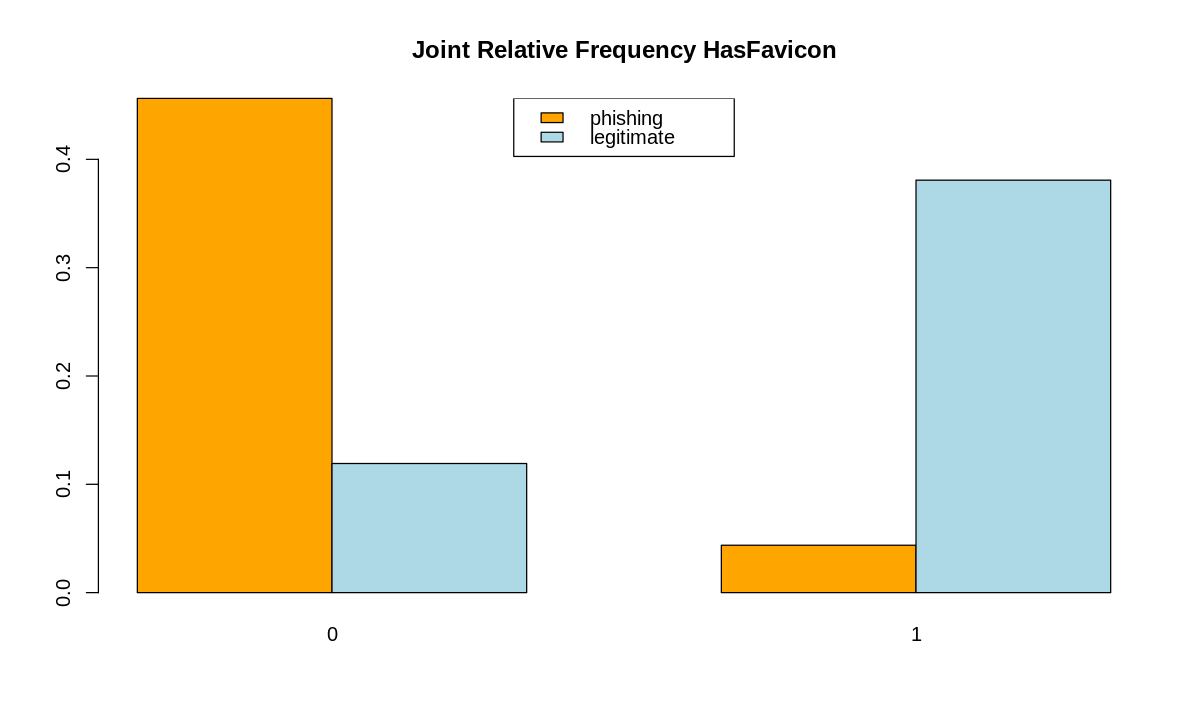

In [ ]:
j_freq <- table(df$label, df$HasFavicon)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasFavicon", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasFavicon, df$label)
spearman <- cor(df$HasFavicon, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.6818527
Spearman: 	 0.6818527

### 19. Feature **HasSocialNet**

In [ ]:
# dispersion
summary(df$HasSocialNet)

cat('\nvar: ', var(df$HasSocialNet), '\n')
cat('std: ', sd(df$HasSocialNet))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4509  1.0000  1.0000 


var:  0.2476145 
std:  0.4976088

#### Joint Relative Frequency

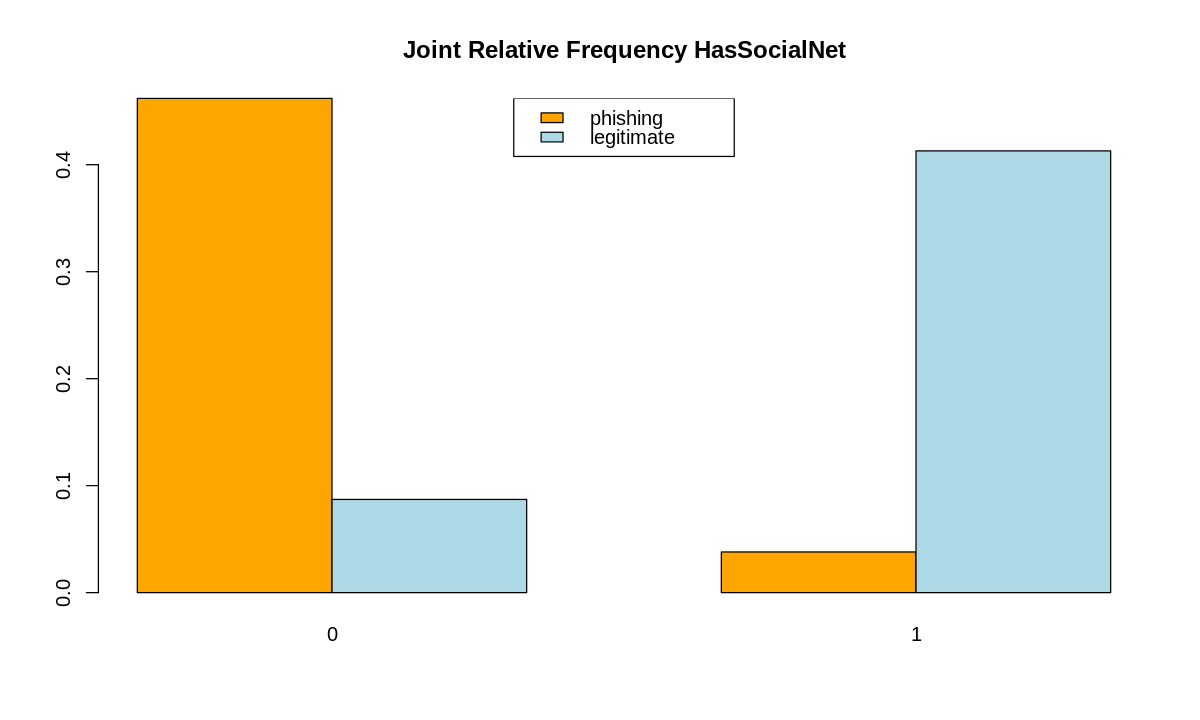

In [ ]:
j_freq <- table(df$label, df$HasSocialNet)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasSocialNet", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasSocialNet, df$label)
spearman <- cor(df$HasSocialNet, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.7533435
Spearman: 	 0.7533435

### 20. Feature **HasCopyrightInfo**

In [ ]:
# dispersion
summary(df$HasCopyrightInfo)

cat('\nvar: ', var(df$HasCopyrightInfo), '\n')
cat('std: ', sd(df$HasCopyrightInfo))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3363  1.0000  1.0000 


var:  0.223234 
std:  0.4724765

#### Joint Relative Frequency

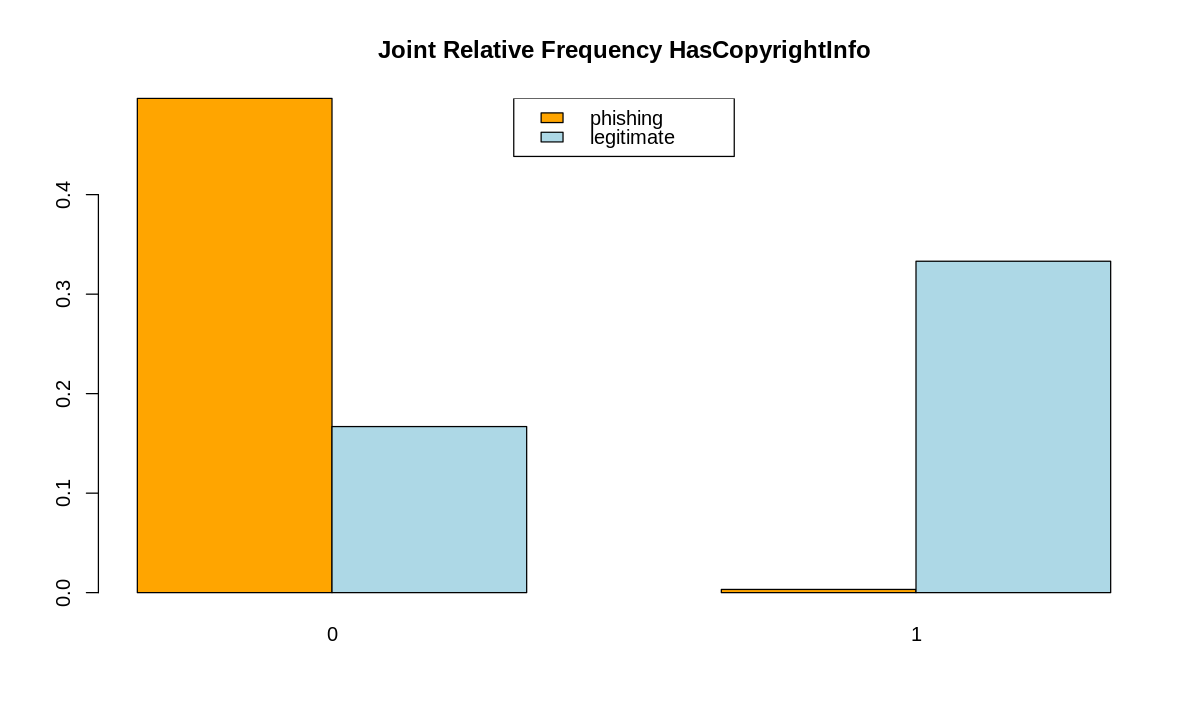

In [ ]:
j_freq <- table(df$label, df$HasCopyrightInfo)
j_freq_rel <- prop.table(j_freq)
# j_freq_rel

# barplot dimension
options(repr.plot.width = 10, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency HasCopyrightInfo", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Correlation with label

In [ ]:
pearson <- cor(df$HasCopyrightInfo, df$label)
spearman <- cor(df$HasCopyrightInfo, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.6980806
Spearman: 	 0.6980806

### 21. Feature **NoOfExternalFiles**


In [ ]:
# dispersion
summary(df$NoOfExternalFiles)

cat('\nvar: ', var(df$NoOfExternalFiles), '\n')
cat('std: ', sd(df$NoOfExternalFiles))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   13.00   20.00   28.39   33.00  218.00 


var:  875.7875 
std:  29.59371

#### Distribution form

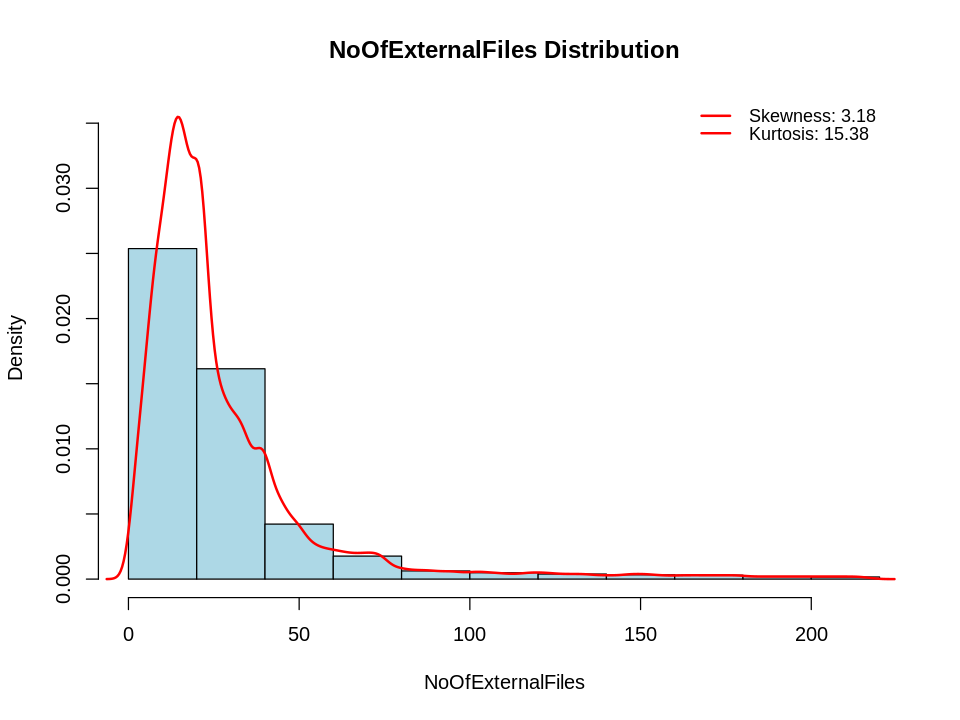

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

dens <- density(df$NoOfExternalFiles)

hist(df$NoOfExternalFiles,
     main = "NoOfExternalFiles Distribution",
     xlab = "NoOfExternalFiles",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens$y))
    )

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$NoOfExternalFiles)
kurtosis_value <- kurtosis(df$NoOfExternalFiles)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

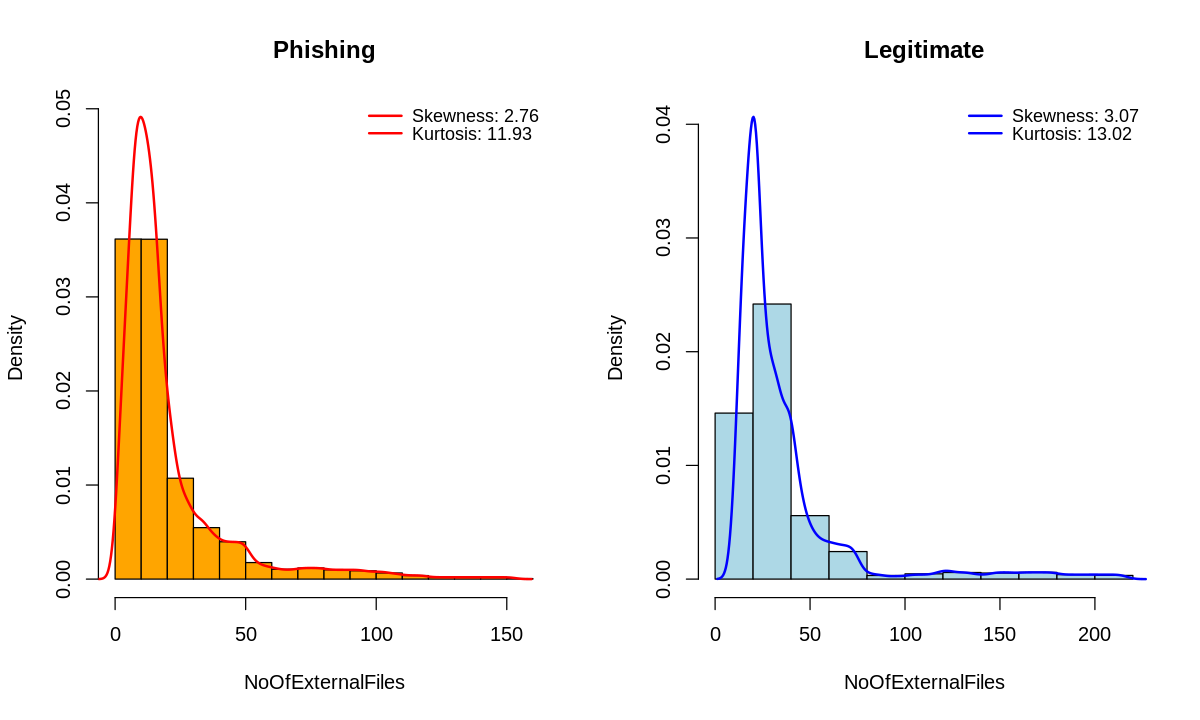

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Sturges rule
n_0 <- length(df_0$NoOfExternalFiles)
h_sturges_0 <- (max(df_0$NoOfExternalFiles) - min(df_0$NoOfExternalFiles)) / sqrt(n_0)
dens_0 <- density(df_0$NoOfExternalFiles, bw = h_sturges_0)

n_1 <- length(df_1$NoOfExternalFiles)
h_sturges_1 <- (max(df_1$NoOfExternalFiles) - min(df_1$NoOfExternalFiles)) / sqrt(n_1)
dens_1 <- density(df_1$NoOfExternalFiles, bw = h_sturges_1)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$NoOfExternalFiles)
kurtosis_value_0 <- kurtosis(df_0$NoOfExternalFiles)

skw_value_1 <- skewness(df_1$NoOfExternalFiles)
kurtosis_value_1 <- kurtosis(df_1$NoOfExternalFiles)

par(mfrow = c(1, 2))

# Phishing
hist(df_0$NoOfExternalFiles,
     main = "Phishing",
     xlab = "NoOfExternalFiles",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_0$y))
     )

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$NoOfExternalFiles,
     main = "Legitimate",
     xlab = "NoOfExternalFiles",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_1$y)))

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

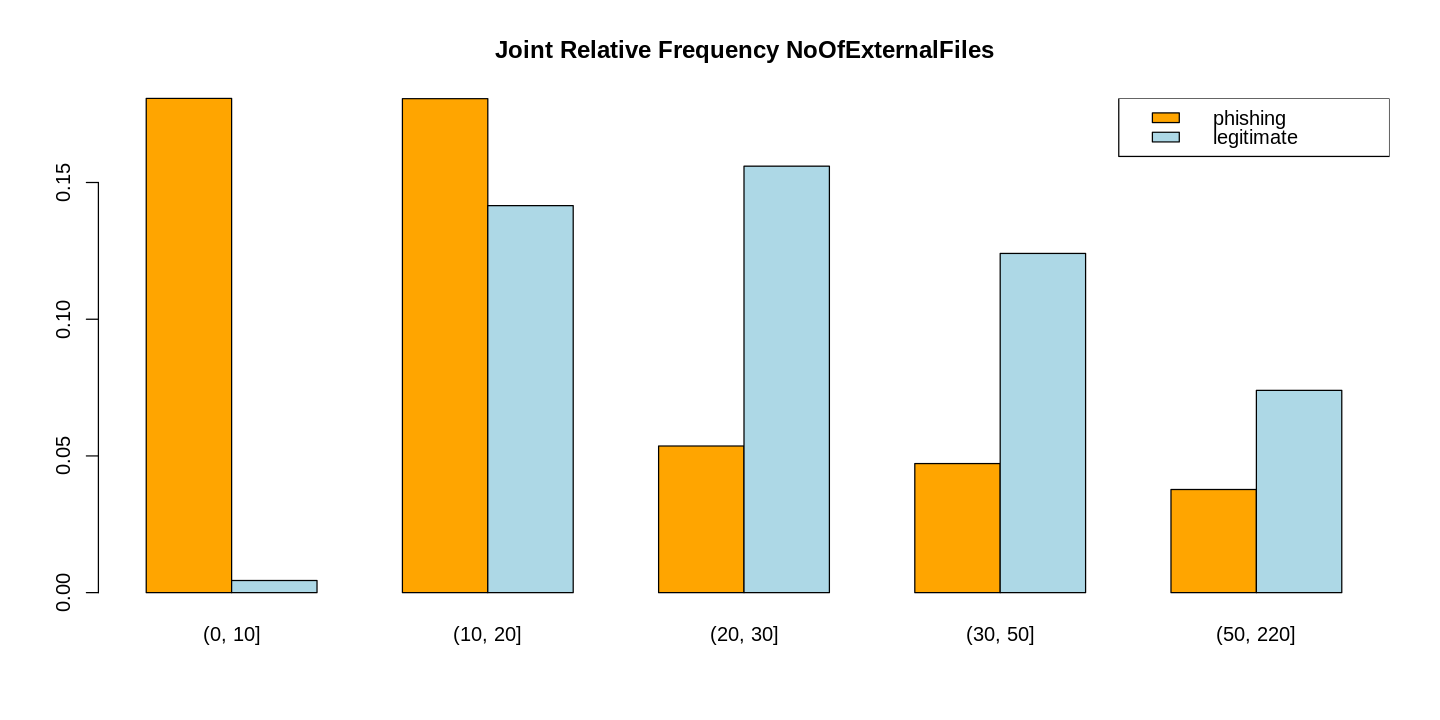

In [ ]:
breaks = c(-1, 10, 20, 30, 50, 220)

labels = c("(0, 10]", "(10, 20]", "(20, 30]", "(30, 50]", "(50, 220]")

j_freq <- table(df$label, cut(df$NoOfExternalFiles, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfExternalFiles", beside = TRUE)

legend("topright", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfExternalFiles)
summary(df_1$NoOfExternalFiles)

outliers <- count_outliers(df, "NoOfExternalFiles")
outliers_0 <- count_outliers(df_0, "NoOfExternalFiles")
outliers_1 <- count_outliers(df_1, "NoOfExternalFiles")

cat('\nn. outliers NoOfExternalFiles: \t\t', outliers)
cat('\nn. outliers NoOfExternalFiles (0): \t', outliers_0)
cat('\nn. outliers NoOfExternalFiles (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     8.0    13.0    20.3    22.0   153.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.00   19.00   25.00   36.48   39.00  218.00 


n. outliers NoOfExternalFiles: 		 797
n. outliers NoOfExternalFiles (0): 	 523
n. outliers NoOfExternalFiles (1): 	 429

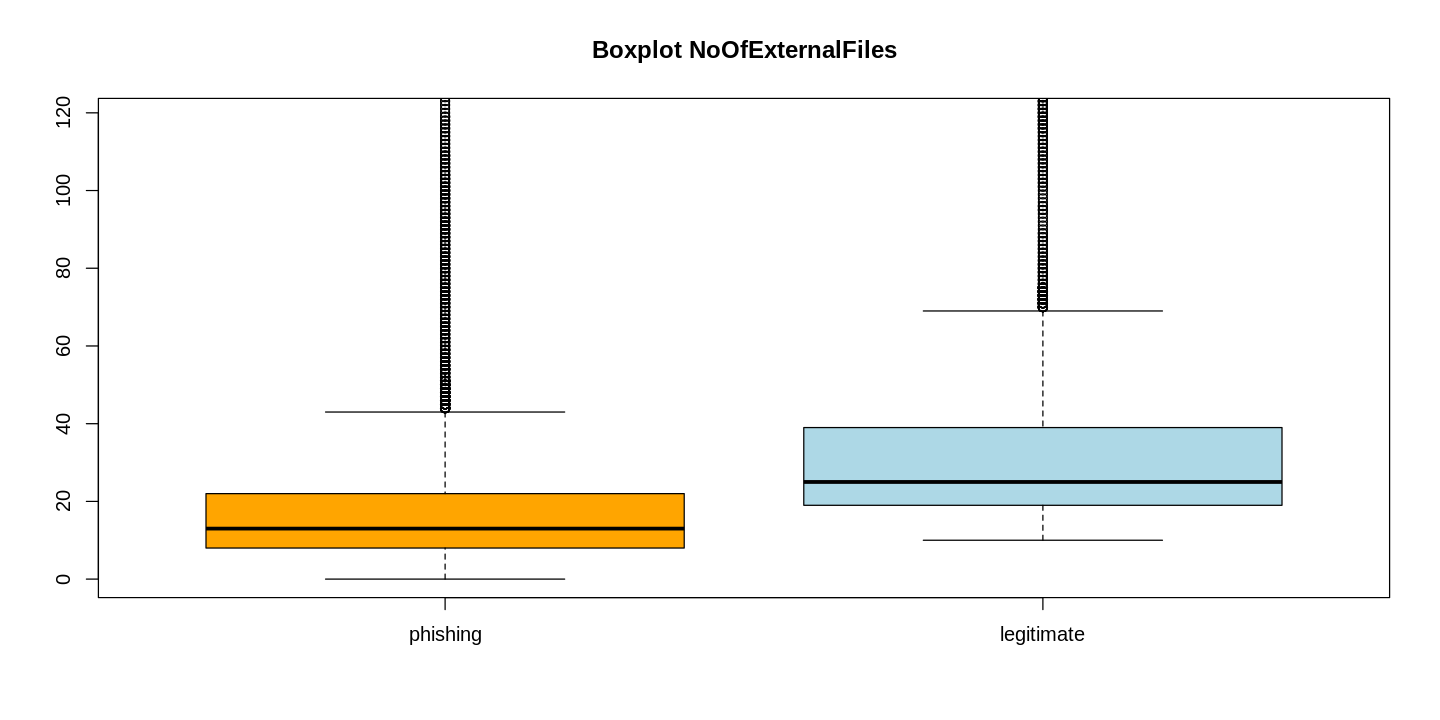

In [ ]:
boxplot(df_0$NoOfExternalFiles, df_1$NoOfExternalFiles,
        main = 'Boxplot NoOfExternalFiles', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfExternalFiles), quantile(df_1$NoOfExternalFiles, 0.95)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfExternalFiles")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 12.69107 M2 = 13.30893 
Overlap df_1: M1 = 24.55866 M2 = 25.44134 


#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfExternalFiles, df$label)
spearman <- cor(df$NoOfExternalFiles, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.2734854
Spearman: 	 0.4708896

### 22. Feature **NoOfReference**

In [ ]:
# dispersion
summary(df$NoOfReference)

cat('\nvar: ', var(df$NoOfReference), '\n')
cat('std: ', sd(df$NoOfReference))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    7.00   14.00   30.41   30.00  450.00 


var:  2443.94 
std:  49.43622

#### Distribution form

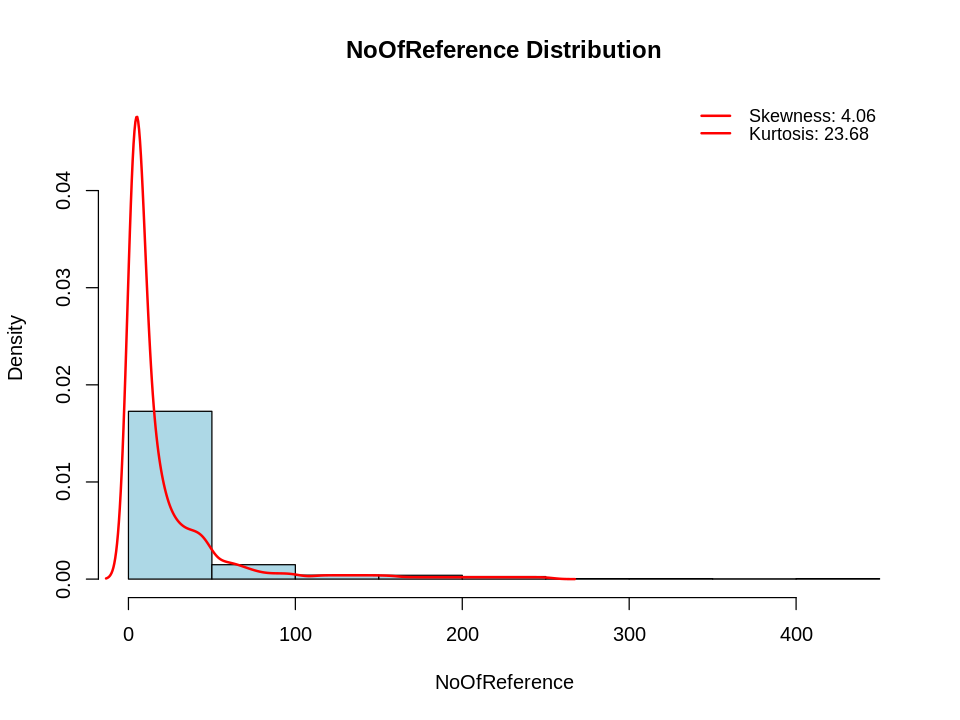

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

n_0 <- length(df$NoOfReference)
h_sturges_0 <- (max(df$NoOfReference) - min(df$NoOfReference)) / sqrt(n_0)
dens <- density(df_0$NoOfReference, bw = h_sturges_0)

hist(df$NoOfReference,
     main = "NoOfReference Distribution",
     xlab = "NoOfReference",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens$y))
    )

lines(dens, col = "red", lwd = 2)

skw_value <- skewness(df$NoOfReference)
kurtosis_value <- kurtosis(df$NoOfReference)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value, 2)),
                  paste("Kurtosis:", round(kurtosis_value, 2))),
       col = c("red", "red"), lty = c(1,1), lwd = c(2, 2),
       bty = "n", cex = 0.9, seg.len = 1.5)

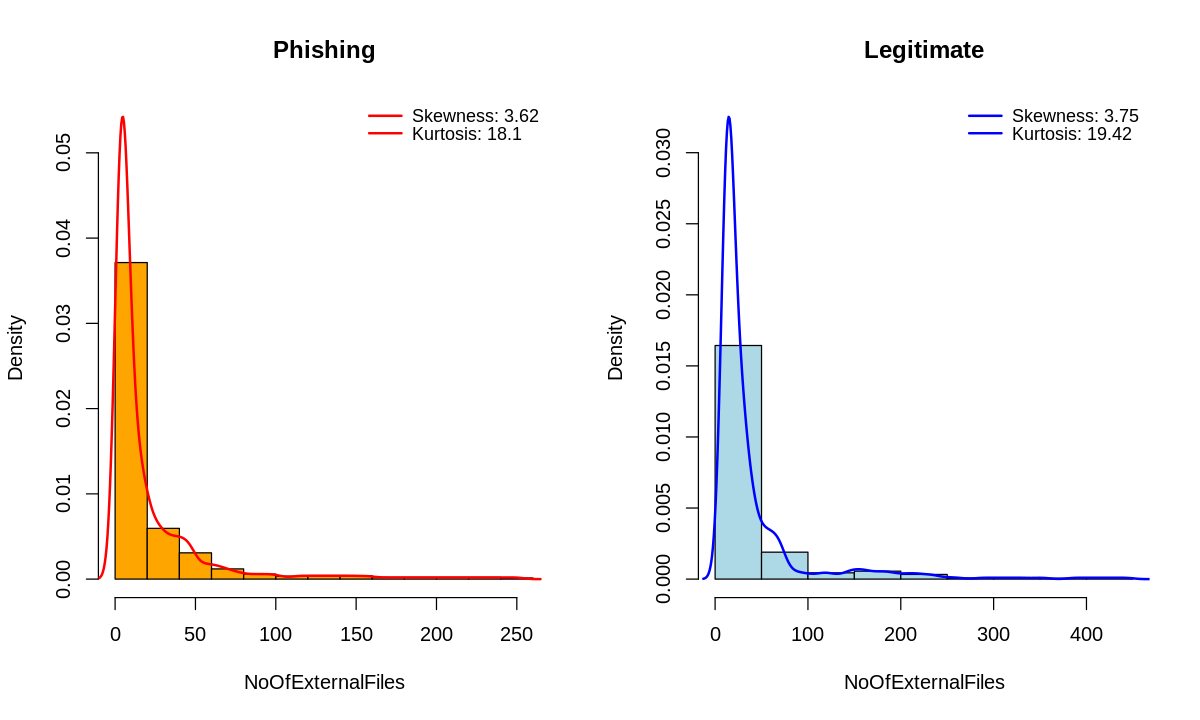

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Sturges rule
n_0 <- length(df_0$NoOfReference)
h_sturges_0 <- (max(df_0$NoOfReference) - min(df_0$NoOfReference)) / sqrt(n_0)
dens_0 <- density(df_0$NoOfReference, bw = h_sturges_0)

n_1 <- length(df_1$NoOfReference)
h_sturges_1 <- (max(df_1$NoOfReference) - min(df_1$NoOfReference)) / sqrt(n_1)
dens_1 <- density(df_1$NoOfReference, bw = h_sturges_1)

# skewness and kurtosis
skw_value_0 <- skewness(df_0$NoOfReference)
kurtosis_value_0 <- kurtosis(df_0$NoOfReference)

skw_value_1 <- skewness(df_1$NoOfReference)
kurtosis_value_1 <- kurtosis(df_1$NoOfReference)

par(mfrow = c(1, 2))

# Phishing
hist(df_0$NoOfReference,
     main = "Phishing",
     xlab = "NoOfExternalFiles",
     ylab = "Density",
     col = "orange",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_0$y))
     )

lines(dens_0, col = "red", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_0, 2)),
                  paste("Kurtosis:", round(kurtosis_value_0, 2))),
       col = c("red", "red"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)


# Legitimate
hist(df_1$NoOfReference,
     main = "Legitimate",
     xlab = "NoOfExternalFiles",
     ylab = "Density",
     col = "lightblue",
     border = "black",
     freq = FALSE,
     ylim = c(0, max(dens_1$y)))

lines(dens_1, col = "blue", lwd = 2)

legend("topright",
       legend = c(paste("Skewness:", round(skw_value_1, 2)),
                  paste("Kurtosis:", round(kurtosis_value_1, 2))),
       col = c("blue", "blue"),
       lty = c(1,1),
       lwd = c(2,2),
       bty = "n",
       cex = 0.9, inset = c(-0.20, 0), seg.len = 1.2, x.intersp = 0.4)

# Reset layout
par(mfrow = c(1, 1))

#### Joint Relative Frequency

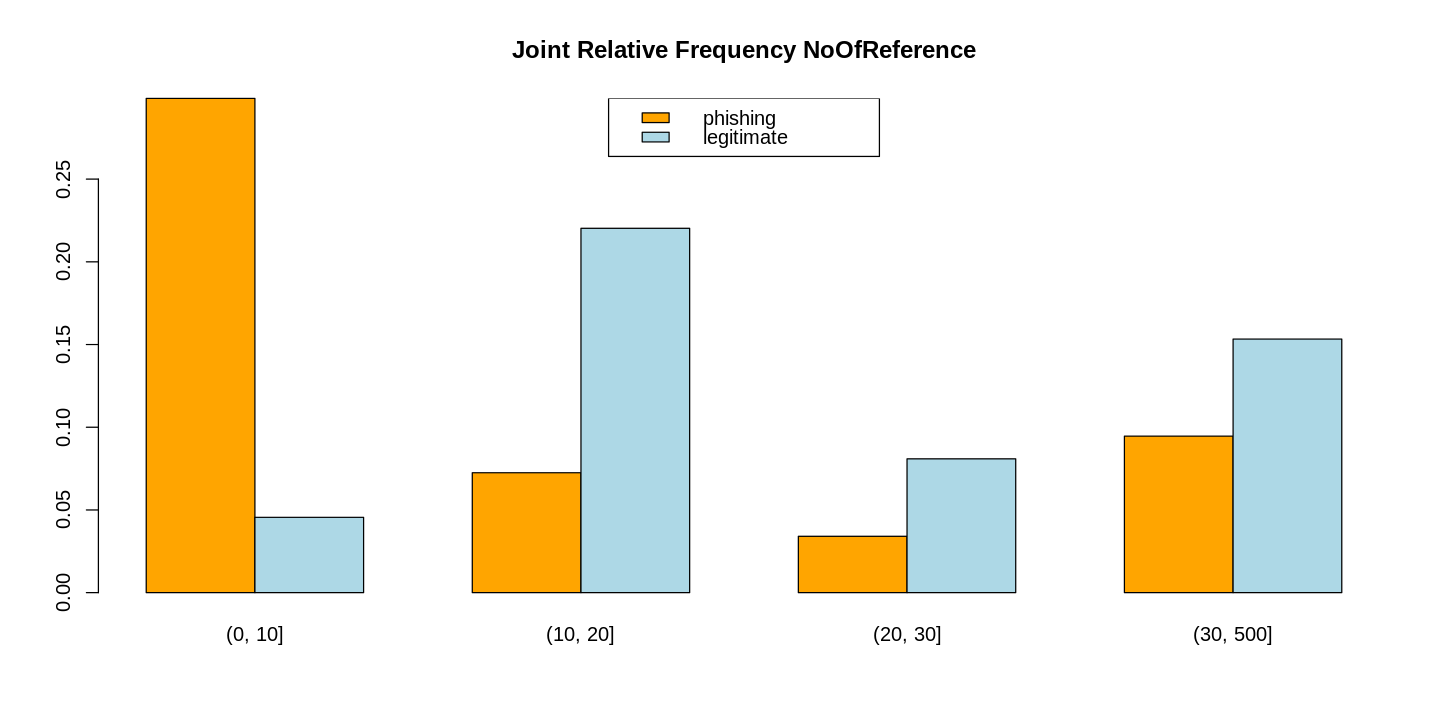

In [ ]:
breaks = c(-1, 10, 20, 30, 500)

labels = c("(0, 10]", "(10, 20]", "(20, 30]", "(30, 500]")

j_freq <- table(df$label, cut(df$NoOfReference, breaks = breaks, labels = labels))

j_freq_rel <- prop.table(j_freq)

# barplot dimension
options(repr.plot.width = 12, repr.plot.height = 6)

barplot(j_freq_rel, col = c("orange", "lightblue"),
        main = "Joint Relative Frequency NoOfReference", beside = TRUE)

legend("top", legend = c("phishing", "legitimate"),
       fill = c("orange", "lightblue"), bty = "o")

#### Outliers and overlap median

In [ ]:
summary(df_0$NoOfReference)
summary(df_1$NoOfReference)

outliers <- count_outliers(df, "NoOfReference")
outliers_0 <- count_outliers(df_0, "NoOfReference")
outliers_1 <- count_outliers(df_1, "NoOfReference")

cat('\nn. outliers NoOfReference: \t', outliers)
cat('\nn. outliers NoOfReference (0): \t', outliers_0)
cat('\nn. outliers NoOfReference (1): \t', outliers_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    4.00    8.00   20.98   21.00  254.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6.00   14.00   19.00   39.85   36.00  450.00 


n. outliers NoOfReference: 	 1007
n. outliers NoOfReference (0): 	 553
n. outliers NoOfReference (1): 	 571

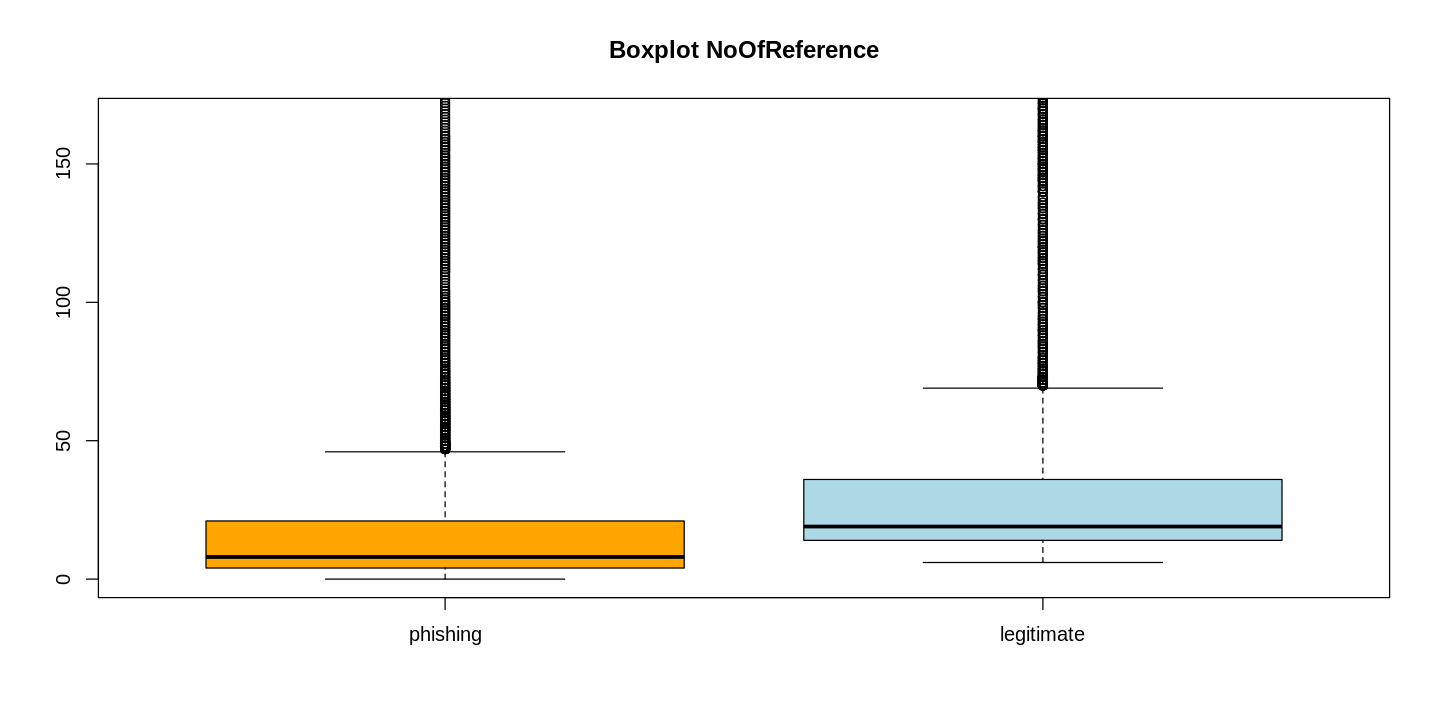

In [ ]:
boxplot(df_0$NoOfReference, df_1$NoOfReference,
        main = 'Boxplot NoOfReference', col = c('orange', 'lightblue'),
        ylim = c(min(df_0$NoOfReference), quantile(df_1$NoOfReference, 0.95)),
        names = c('phishing', 'legitimate'))

In [ ]:
overlap_results <- calculate_overlap_median(df_0, df_1, "NoOfReference")

cat("Overlap df_0: M1 =", overlap_results$df_0$M1, "M2 =", overlap_results$df_0$M2, "\n")
cat("Overlap df_1: M1 =", overlap_results$df_1$M1, "M2 =", overlap_results$df_1$M2, "\n")

Overlap df_0: M1 = 7.624865 M2 = 8.375135 
Overlap df_1: M1 = 18.51453 M2 = 19.48547 


#### Correlation with label

In [ ]:
pearson <- cor(df$NoOfReference, df$label)
spearman <- cor(df$NoOfReference, df$label, method = 'spearman')

cat('Pearson: \t', pearson)
cat('\nSpearman: \t', spearman)

Pearson: 	 0.1908555
Spearman: 	 0.4310815

## **Saving filtered real dataset**

In [ ]:
write.csv(df, "Phishing_URL_Synthetic_Dataset_3_Filtered.csv", row.names = FALSE)

In [ ]:
download.file("https://drive.google.com/uc?id=1Sd9obB-lHiCWhDgXsmR6rtXpeupCnWYX&export=download", "Phishing_URL_Synthetic_Dataset_3_Filtered.csv")

In [ ]:
df <- read.csv('Phishing_URL_Synthetic_Dataset_3_Filtered.csv', sep = ",")

In [ ]:
str(df)

'data.frame':	10124 obs. of  21 variables:
 $ URLLength            : int  45 60 28 75 90 55 42 100 39 62 ...
 $ DomainLength         : int  25 30 18 40 50 35 22 60 27 33 ...
 $ TLDEncoding          : num  0.32 0.2 0.4 0.1 0.25 0.35 0.3 0.15 0.38 0.27 ...
 $ NoOfLettersInURL     : int  30 35 12 45 40 28 20 50 15 32 ...
 $ NoOfDigitsInURL      : int  4 5 2 10 6 4 2 8 3 5 ...
 $ NoOfSpecialCharsInURL: int  5 4 1 6 2 3 2 8 2 5 ...
 $ IsHTTPS              : int  0 0 0 0 0 0 0 0 1 0 ...
 $ LineOfCode           : int  300 210 100 400 150 320 250 500 80 90 ...
 $ LargestLineLength    : int  2000 1800 1500 3000 2500 2200 1000 4500 900 2000 ...
 $ HasTitle             : int  0 0 1 0 1 0 0 0 0 0 ...
 $ NoOfReference        : int  5 2 8 0 3 4 2 10 1 0 ...
 $ DomainTitleMatchScore: num  10.5 0 15 0 5.5 20 0 25.4 10 0 ...
 $ URLTitleMatchScore   : num  25.4 0 22 0 10.2 35.7 0 30.1 12 0 ...
 $ HasFavicon           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Robots               : int  0 0 0 0 0 0 0 0 0 0 ...
 